<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">Разработка модели для прогноза рыночной стоимости автомобилей с пробегом</h1>

Нужно построить модель для определения рыночной стоимости автомобиля. 
Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

<h2 style="color:DodgerBlue">Описание данных</h2>

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

<h2 style="color:DodgerBlue">Общие соображения</h2>

**Особенности разделения данных:**
- Данные в наборе относятся к разному времени. Модель, очевидно, должна прогнозировать стоимость автомобиля на основании ранее размещённых объявлений. Возможно, если разброс по времени существенный, нужно использовать <code>TimeSeriesSplit</code> для разбиения на трейн/тест и кросс-валидации.

**Feature engineering:**
- Наверняка на цену влияет возраст автомобиля, т.е. разница между датой публикации объявления и датой выпуска автомобиля. Точность выше, чем месяц, для этого признака наверняка не нужна
- PostalCode позволяет определить место, где автомобиль выставлен на продажу. Скорее всего, можно объединить почтовые индексы по районам или городам.

**Оценка корректности данных:**
- По дате создания анкеты, дате последней активности владельца и дате скачивания анкеты, вероятно, можно оценить, как долго продавался автомобиль. Оценить адекватные объявления и аномалии цен.

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
from collections import namedtuple
from ipywidgets import IntProgress

from sklearn.base import TransformerMixin, BaseEstimator

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, ParameterGrid

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, Lasso
from catboost import CatBoostRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder, OrdinalEncoder, CountEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.dummy import DummyRegressor

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('whitegrid')

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None) 

In [2]:
#функция для построения диаграммы пропущенных значений
def nan_estimation_graph(df, autosize=True, figsize=(8,6)):
    
    if df.isna().sum().sum() > 0:
        nan_df = pd.DataFrame()
        nan_df['percent'] = (100*df.isna().sum()/len(df)).sort_values()
        nan_df['count'] = df.isna().sum().sort_values()
        nan_df = nan_df[nan_df['count'] > 0]

        nan_percent_max = nan_df['percent'].max()

        colors = (nan_df['percent']  / nan_percent_max ).tolist()
        colors = [(color, 0.5*(1-color), 0.5*(1-color)) for color in colors] #подготовка градиентной окраски

        if autosize:
            fig_height = int(len(nan_df)*0.2) + 2
            figsize=(8, fig_height)

        plt.figure(figsize=figsize)
        plt.grid(alpha=0.8)
        plt.xticks(range(0,110,2))
        plt.xlim(0, nan_percent_max + 5)
        plt.xlabel('% пропущенных значений')
        plt.ylim(-1, len(nan_df))
        plt.ylabel('признак')

        xpos = nan_df['percent'] + nan_percent_max*0.02

        bbox=dict(boxstyle="round", fc=(1, 1, 1, 0.8))

        for x, y, txt in zip( xpos, nan_df.index, nan_df['count'] ):
            plt.text(x, y, f'{txt} шт.', verticalalignment='center', bbox=bbox)

        plt.hlines(y=nan_df.index, xmin = 0, xmax = nan_df['percent'], alpha=0.7, 
                   linewidth=10, colors=colors)
        plt.title(f'Оценка количества и доли (%) пропусков в данных\nВсего записей: {len(df)}, из них с пропусками:', 
                  size=14)
        plt.tight_layout()
    else:
        print('В наборе данных нет пропущенных значений')

In [3]:
#класс Imputer для заполнения пропущенных значений по словарю
#словарь составляется из комбинаций признаков predictors 
#и соответствующего значения target

class DictionaryImputer(TransformerMixin, BaseEstimator):
    def __init__(self, predictors, target, strategy='most_frequent'):
        #predictors - какие признаки использовать в качестве ключей, list
        #target - в каком признаке заполняем пропуски, str
        #strategy - стратегия: 'most_frequent', 'mean', 'median' и т.д.
        self.predictors = predictors
        self.target = target
        self.strategy = strategy
        
        
    def fit(self, X, y=None):
        #собираю словарь 
        #ключи - кортежи из predictors 
        #значения - самое частое/среднее/медианное значение tаrget для совокупности predictors
        #y=None - для совместимости с sklearn pipeline
        
        if self.strategy == 'most_frequent':
            #для моды написал свою функцию
            #т.к. библиотечные валятся при отсутствии значений в массиве
            def _mode_func(x):
                try:
                    return x.mode()[0]
                except:
                    return np.nan
                
            self.filler_dict = X.groupby(self.predictors)[self.target].agg(lambda x: _mode_func(x)).to_dict()            
        else:
            self.filler_dict = X.groupby(self.predictors)[self.target].agg(self.strategy).to_dict()
        return self
    
    def transform(self, X):
        
        #объявляю функцию, которая собирает ключ - кортеж значений Predictors
        #и возвращает либо соответствующее ключу значение из словаря, либо NaN       
        
        def _fill_func(row):
            if len(self.predictors) > 1:
                return self.filler_dict.get(tuple(row[col] for col in self.predictors), np.nan)
            
            elif len(self.predictors) == 1:
                return self.filler_dict.get(row[self.predictors[0]], np.nan)
        
        #заполняю пропуски. применяю __fill_func только для объектов с пропусками в target
        
        X.loc[X[self.target].isna(), self.target] = X[X[self.target].isna()].apply(_fill_func, axis=1)
        return X

In [4]:
#класс Encoder для кодирования по словарю
#словарь составляется из названий категорий кодируемого признака
#и соответствующего значения средней цены авто для каждой категории
#средняя цена считается по трейну, утечки тут нет

class DictionaryEncoder:
    def __init__(self, encoding_base, target, strategy='mean', is_model=True):
        #encoding_base - на основании чего кодировать, str
        #target - какой признак кодировать, str
        #strategy - стратегия: 'most_frequent', 'mean', 'median' и т.д.
        #is_model - флаг, является ли target признаком 'Model'
        self.base = encoding_base
        self.target = target
        self.strategy = strategy
        self.flag = is_model       
    
    
    def fit(self, X, y):
        
        
        def _mode_func(x):
            try:
                return x.mode()[0]
            except:
                return np.nan
        
        
        X.loc[:, 'Price'] = y
        
        self.grouper = self.target
        
        if self.flag:
            self.grouper = ['Brand', self.target]   
    
        if self.strategy == 'most_frequent':     
            self.encoder_dict = X.groupby(self.grouper)[self.base].agg(lambda x: _mode_func(x)).to_dict()            
        else:
            self.encoder_dict = X.groupby(self.grouper)[self.base].agg(self.strategy).to_dict()
        
        self.universal_value = X[self.base].mean()
        
        X.drop(columns=['Price'], inplace=True)
        
        return self
        
    
    def transform(self, X):
        
        
        def _fill_func(row):
            if self.flag:
                return self.encoder_dict.get(tuple(row[col] for col in self.grouper), self.universal_value)
            return self.encoder_dict.get(row[self.grouper], self.universal_value)
    
        
        X[self.target] = X.apply(_fill_func, axis=1)
        X[self.target] = ( X[self.target] - X[self.target].mean() ) / X[self.target].std()
        
        return X
    
    
    def fit_transform(self, X, y, **fit_params):
        return self.fit(X, y, **fit_params).transform(X)

In [5]:
#функция, которая делает кросс-валидацию и считает время выполнения кросс валидации и метрику
def cvs_plus_time(model, X, y, cv=5, scoring='neg_root_mean_squared_error'):
    start = datetime.now()
    cvs = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    end = datetime.now()
    total_time = end - start
    avg_time = total_time / cv
    cvs.mean()*(-1)
    result = namedtuple('cross_validation_results', ('rmse', 'avg_rmse', 'total_time', 'avg_time', 'n_folds'))
    return result(cvs*(-1), cvs.mean()*(-1), total_time, avg_time, cv)

(некоторые функции оставил в теле документа, чтобы сохранить логику проекта; и там удобнее было отлаживать)

<h1 style="color:SteelBlue"> 1. Осмотр и очистка данных</h1>

<h2 style="color:DodgerBlue">1.1 Загрузка, общая информация о данных</h2>

In [6]:
link = 'datasets/ML/'
df = pd.read_csv(link+'autos.csv', 
                parse_dates=['DateCrawled', 'DateCreated', 'LastSeen']
                )

In [7]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [9]:
# Получение списка текстовых признаков
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Текстовые признаки:")
print(object_cols)

Текстовые признаки:
['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']


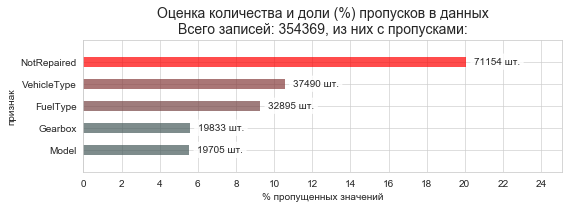

In [10]:
nan_estimation_graph(df)

In [11]:
df.describe().round(1)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.0,354369.0,354369.0,354369.0,354369.0,354369.0,354369.0
mean,4416.7,2004.2,110.1,128211.2,5.7,0.0,50508.7
std,4514.2,90.2,189.9,37905.3,3.7,0.0,25783.1
min,0.0,1000.0,0.0,5000.0,0.0,0.0,1067.0
25%,1050.0,1999.0,69.0,125000.0,3.0,0.0,30165.0
50%,2700.0,2003.0,105.0,150000.0,6.0,0.0,49413.0
75%,6400.0,2008.0,143.0,150000.0,9.0,0.0,71083.0
max,20000.0,9999.0,20000.0,150000.0,12.0,0.0,99998.0


In [12]:
for col in object_cols:
    display(df[col].value_counts())

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

manual    268251
auto       66285
Name: Gearbox, dtype: int64

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [13]:
print('Полных дублей в данных:', df.duplicated().sum())

Полных дублей в данных: 4


In [14]:
df.drop_duplicates(inplace=True)
print('Полных дублей в данных после очистки:', df.duplicated().sum())

Полных дублей в данных после очистки: 0


В данных 354369 объектов, 16 признаков, один целевой. Есть пропуски в признаках <code>NotRepaired, VehicleType, FuelType, Gearbox, Model</code>. Все эти признаки - категориальные.

В признаках <code>RegistrationYear, Power</code>  есть аномальные значения. В признаках <code>Price, Power, RegistrationMonth</code> есть нулевые значения. По смыслу признаков нулей там не может быть. Скорее всего, нулями заполнены пропуски.

Признак <code>NumberOfPictures</code> содержит только нули и бесполезен.

<code>PostalCode</code>: по ценам в евро и почтовым индексам, в основном, из пяти цифр, можно предположить, что перед нами база данных по крупной европейской стране (Франция, Италия, Испания, Германия и т.д.). Если пробить несколько почтовых индексов, например [22043](https://www.geonames.org/postalcode-search.html?q=22043&country=), [60326](https://www.geonames.org/postalcode-search.html?q=60326&country=), [66954](https://www.geonames.org/postalcode-search.html?q=66954&country=), [70435](https://www.geonames.org/postalcode-search.html?q=70435&country=), то получится, что они одновременно присутствуют только в Германии. Так что, судя по всему, перед нами база данных, в основном, по Германии. Есть ещё короткие почтовые коды из 4 цифр. Либо это старые коды Германии, либо данные по другим странам.

В категориальных признаках больше всего вариантов в моделях автомобилей. 250 вариантов. Использовать OneHotEncoder для этого признака нежелательно (сильно вырастет число фич и время обучения). Непонятна разница между *petrol* и *gasoline* в типах топлива. Похоже, это одно и то же. Может быть, данные с разных площадок (?). И точно, https://www.autoscout24.de и https://www.mobile.de/ : [autoscout24](https://www.autoscout24.com/refinesearch?sort=standard&desc=0&ustate=N%2CU&atype=C) gasoline, а  [mobile](https://suchen.mobile.de/fahrzeuge/search.html?vc=Car&dam=0&sfmr=false) - petrol. Странно, что нет дизеля. 

Кстати, в пользу версии о немецких площадках говорит бренд sonstige_autos. В переводе с немецкого это "другие автомобили", т.е. просто other.

<h2 style="color:DodgerBlue">1.2 Поиск аномалий и очистка данных</h2>

<h3 style="color:DodgerBlue">1.2.1 Количественные и datetime признаки</h3>

**Признак <code>NumberOfPictures</code>** содержит только нули и бесполезен. Его удалю.

In [15]:
df.drop(columns=['NumberOfPictures'], inplace=True)

**Целевой признак - <code>Price</code>**
Посмотрю распределение и наличие нулей/очень малых цен.

Можно ожидать распределение с тяжелым хвостом, типа хи-квадрат распределения. С малым числом значений в районе нуля, последующим плавным и быстрым ростом, плавным пиком (с характером "колокола") и медленным спадом.

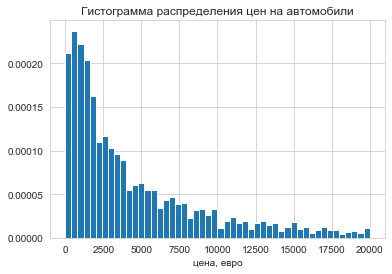

In [16]:
plt.hist(df['Price'], bins=50, density=True)
plt.title('Гистограмма распределения цен на автомобили')
plt.xlabel('цена, евро')
plt.show()

Ну, что-то похожее на ожидаемое, действительно, получено. Но возле нуля довольно много значений.

Понятно, что нулевые цены - это, по сути, отсутствующие данные. Эти объекты удалю, т.к. модель нельзя обучить прогнозу целевого признака без самого целевого признака.

In [17]:
print('Объектов с нулевой ценой:', df[df['Price']==0].shape[0])
df.drop(index=df[df['Price']==0].index, inplace=True)
print('Очищено')
print('Объектов с нулевой ценой:', df[df['Price']==0].shape[0])

Объектов с нулевой ценой: 10772
Очищено
Объектов с нулевой ценой: 0


Судя по данным https://www.autoscout24.ru/, https://www.mobile.de, действительно, в ряде объявлений указаны цены 1, 2 и т.д. евро. Однако, судя по фото, это вполне нормальные автомобили, которые столько не стоят. Возможно, цена указана специально, чтобы с владельцем чаще связывались, либо ещё по каким-то причинам (ошибка в нулях после запятой). Например, вот одно из объявлений, где владелец пишет "Verkaufe Alufelgensatz mit Winterreifen ( Audi A6 Avant gibt es Gratis dazu. ) (Продам комплект легкосплавных дисков с зимними шинами(Audi A6 Avant доступен бесплатно)" В любом случае, такие цены не являются адекватными. Судя по тому же сайту, более-менее адекватные цены начинаются с 50 евро (это маленькие автомобили, которым по 20-30 лет, с большим пробегом). В моём понимании, дешевле 500 евро автомобиль, который способен самостоятельно двигаться, стоить не может. Тем не менее, в Европе, возможно, другие принципы формирования цен на старые авто. Посмотрю, сколько объектов ценой менее 50 евро.

In [18]:
print('Объектов стоимостью до 50 евро включительно:', len(df[df['Price']<50]))

Объектов стоимостью до 50 евро включительно: 1651


На мой взгляд, объекты с ценой до 50 евро однозначно выглядят подозрительно. К тому же их довольно мало (около 0,5%). Удалю эти объекты и оценю полученное распределение.

In [19]:
df.drop(index=df[df['Price']<50].index, inplace=True)

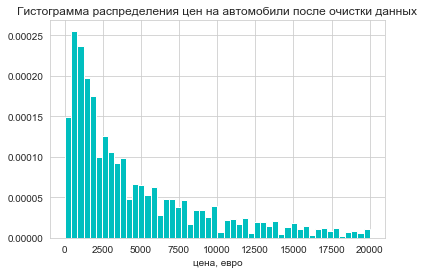

In [20]:
plt.hist(df['Price'], bins=50, density=True, color='c')
plt.title('Гистограмма распределения цен на автомобили после очистки данных')
plt.xlabel('цена, евро')
plt.show()

На мой взгляд, стало чуть лучше.

**Теперь перейдём к RegistrationYear.**

In [21]:
df['RegistrationYear'].describe()

count    341942.000000
mean       2004.079774
std          77.070996
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Явно есть какие-то ошибки. И слишком "молодые", и слишком "старые" объекты. Выделю объекты, которые "моложе" даты объявления о своей продаже.

In [22]:
too_young_1 = (df['RegistrationYear'] - df['DateCreated'].dt.year) > 0
too_young_2 = (
    ((df['RegistrationYear'] - df['DateCreated'].dt.year) == 0)
    &
    ((df['RegistrationMonth'] - df['DateCreated'].dt.month) > 0)
)
too_young = too_young_1 | too_young_2

In [23]:
print('Объектов, которые "моложе" даты своей продажи:', too_young.sum())

Объектов, которые "моложе" даты своей продажи: 18636


In [24]:
df[too_young].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,19386,2016-03-08 09:44:50
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,48499,2016-03-31 21:47:44


Записей довольно много. Не буду удалять их, заполню некорректные года и месяцы np.nan.

In [25]:
df.loc[too_young, 'RegistrationYear'] = np.nan
df.loc[too_young, 'RegistrationMonth'] = np.nan

Что касается "слишком старых" объектов, на сайте https://www.mobile.de действительно встречаются эксклюзивные модели автомобилей, [самая старая модель - 1900 года](https://www.mobile.de/ru/%D0%90%D0%B2%D1%82%D0%BE%D0%BC%D0%BE%D0%B1%D0%B8%D0%BB%D1%8C/%D0%94%D1%80%D1%83%D0%B3%D0%B8%D0%B5-Benz-Patent-Motorwagen-Replika-NACHBAU/vhc:car,pgn:1,pgs:10,srt:year,sro:asc/pg:vipcar/267134179.html). Сразу заменю 'RegistrationYear' у объектов старше 1900 года на NaN И посмотрю распределение у оставшихся объектов по годам выпуска.

In [26]:
df.loc[df.loc[:, 'RegistrationYear'] < 1900, 'RegistrationYear'] = np.nan

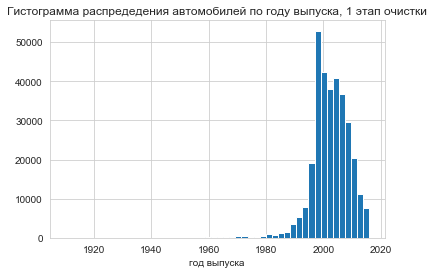

In [27]:
df['RegistrationYear'].hist(bins=50)
plt.title('Гистограмма распредедения автомобилей по году выпуска, 1 этап очистки')
plt.xlabel('год выпуска')
plt.show()

In [28]:
print('99.5% объектов моложе', df['RegistrationYear'].quantile(0.005), 'года')

99.5% объектов моложе 1972.0 года


Я думаю, что автомобили старше 60-70х годов уже, по сути, эксклюзивные модели. К тому же, у нас нет задачи сделать приложение для оценки ретро-автомобилей. Кроме того, анализ данных показывает, что среди автомобилей, обозначенных старыми годами выпуска, много ошибок. Так что заменю для таких автомобилей года регистрации на NaN, т.к. они сомнительны.

In [29]:
print('Объектов старше 1960 г.:', len(df[df['RegistrationYear'] <= 1960]))

Объектов старше 1960 г.: 387


In [30]:
df.loc[df.loc[:, 'RegistrationYear'] < 1960, 'RegistrationYear'] = np.nan

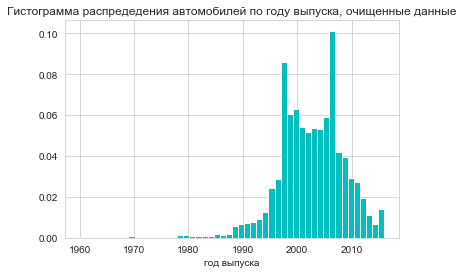

In [31]:
df['RegistrationYear'].hist(bins=50, density=True, color='c')
plt.title('Гистограмма распредедения автомобилей по году выпуска, очищенные данные')
plt.xlabel('год выпуска')
plt.show()

Получили распределение, более-менее близкое к классическим и ожидаемым, с длинным хвостом слева. Однако интересно, что в распределении 2 пика, а между ними провал. И локальный пик на новых авто (это странно, возможно, битые машины). Возможно, работает принцип продажи автомобиля после гарантии, после 5, 10 лет и т.п. Пики как раз примерно на 2006 и конце 90х. И в основном продают автомобили после 10 лет и до 20.

**RegistrationMonth**

In [32]:
df['RegistrationMonth'].value_counts(normalize=True)

3.0     0.100914
6.0     0.089615
0.0     0.088761
4.0     0.083794
5.0     0.082925
7.0     0.077840
10.0    0.074802
11.0    0.069510
12.0    0.069349
9.0     0.068511
1.0     0.067555
8.0     0.064314
2.0     0.062111
Name: RegistrationMonth, dtype: float64

В данных есть месяц 0. Видимо, это объекты, для которых месяц был неизвестен. Это 9.5% данных. Дата регистрации ТС важна с точки зрения определения возраста автомобиля на момент продажи. Его можно рассчитать в годах и месяцах, вычитая дату регистрации из даты публикации анкеты.

Заменю пока 0 на NaN.

In [33]:
df.loc[df.loc[:, 'RegistrationMonth'] == 0, 'RegistrationMonth'] = np.nan

**Посмотрим на даты создания анкет DateCreated и выгрузки данных DateCrawled**

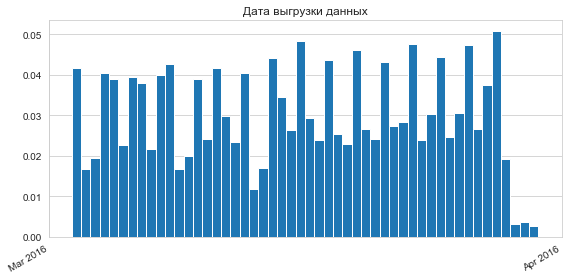

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df['DateCrawled'], bins=50, density=True)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.set_title('Дата выгрузки данных')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

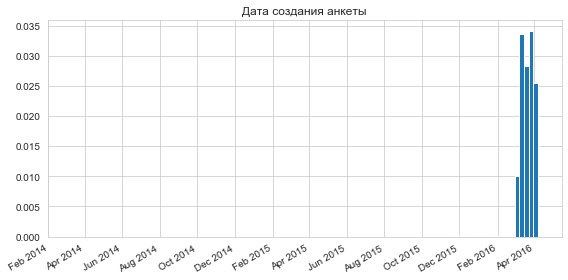

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df['DateCreated'], bins=100, density=True)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.set_title('Дата создания анкеты')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Как видно, почти все анкеты созданы в 2016 году, однако есть некоторое количество "старых" объявлений (долго продаются). Видимо, что-то не так с этими объявлениями.


Судя по всему, после продажи автомобиля объявление из базы удаляется. Добавлю признак, который указывает, сколько объявление уже было размещено в базе к моменту выгрузки данных. Для этого найду разницу DateCrawled - DateCreated.


Алгоритм должен рекомендовать клиенту такую стоимость автомобиля, за которую его можно продать в разумные сроки. На мой взгляд, это в пределах месяца. 
Посмотрю, есть ли объявления, размещённые 30 и более дней. 

In [36]:
time_exposition = df['DateCrawled'] - df['DateCreated']

In [37]:
print('Объявлений страше 30 дней:', len(df[time_exposition.dt.days > 30]))

Объявлений страше 30 дней: 181


Уберу эти объявления, т.к. клиенту нужно рекомендовать адекватные цены.

In [38]:
df.drop(df[time_exposition.dt.days > 30].index, inplace=True)

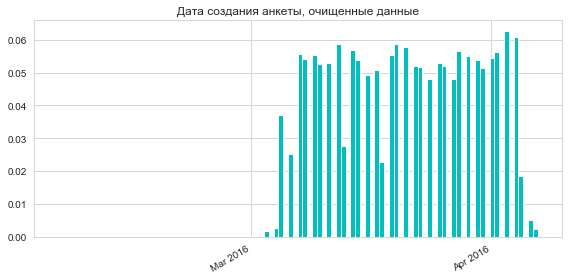

In [39]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(df['DateCreated'], bins=100, density=True, color = 'c')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.set_title('Дата создания анкеты, очищенные данные')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [40]:
print('Объявлений, размещённых до марта (в феврале) 2016:', len(df[df.loc[:, 'DateCreated'].dt.month == 2]))

Объявлений, размещённых до марта (в феврале) 2016: 307


Вряд ли чем-то может быть полезно время последней активности пользователя, разместившего объявление. Судя по данным, информация о последней активности обновляется для всех пользователей каждый раз при скачивании новой анкеты, т.к. большинство пользователей были активны уже после того, как их анкета была скачана из базы. 

Единственное, проверю, что нет некорректных данных в датасете (например, что посетитель ещё не был активен, а анкета уже опубликована)

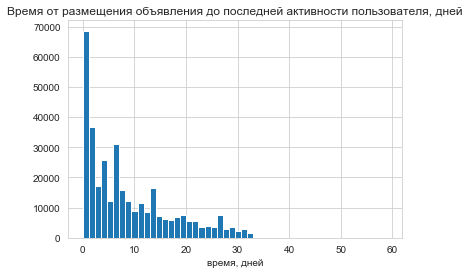

In [41]:
(df['LastSeen'] - df['DateCreated']).dt.days.hist(bins=50)
plt.title('Время от размещения объявления до последней активности пользователя, дней')
plt.xlabel('время, дней')
plt.show()

In [42]:
print('Минимальное время активности пользователя после размещения объявления:', (df['DateCrawled'] - df['DateCreated']).min())

Минимальное время активности пользователя после размещения объявления: 0 days 00:06:39


Многие пользователи не заходят на сайт после размещения объявления. Минимально после размещения объявления пользователь провёл на сайте около 7 минут. Всё вроде бы адекватно.

Собственно, признаки <code>LastSeen и DateCrawled</code>, на мой взгляд, больше не понадобятся. Признак <code>DateCreated</code> оставлю, он может помочь рассчитать возраст авто.

In [43]:
df.drop(columns=['LastSeen','DateCrawled'], inplace = True)

**Power**

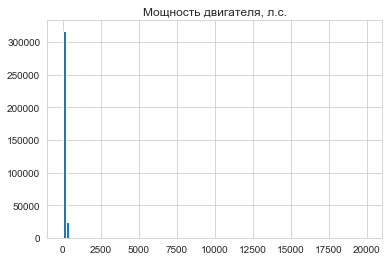

In [44]:
df['Power'].hist(bins=100)
plt.title('Мощность двигателя, л.с.')
plt.show()

Самые мощные модели porshe - это [taycan Turbo S 625 л.с.](https://www.porsche.com/russia/models/taycan/taycan-models/)
Всё, что выше - точно эксклюзив или ошибки (анализ датасета это подтверждает).

In [45]:
df[df['Power'] > 625].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode
1816,3200,small,2004.0,manual,1398,corolla,5000,6.0,petrol,toyota,no,2016-03-22,22043
4060,3100,sedan,2005.0,manual,953,colt,150000,4.0,gasoline,mitsubishi,no,2016-04-03,60326
5328,500,wagon,1999.0,manual,1001,astra,150000,7.0,petrol,opel,NaN,2016-03-29,33154
6504,3000,small,2009.0,manual,771,punto,125000,NaN,petrol,fiat,NaN,2016-03-14,40721
7661,1499,small,1999.0,manual,7515,lupo,150000,4.0,petrol,volkswagen,NaN,2016-04-02,65830


Заменю NaN всё, что более 625 л.с. Также заменю на NaN нулевые значения (которые, по сути, и являются NaN)

In [46]:
df.loc[df.loc[:, 'Power'] > 625, 'Power'] = np.NaN
df.loc[df.loc[:, 'Power'] == 0, 'Power'] = np.NaN

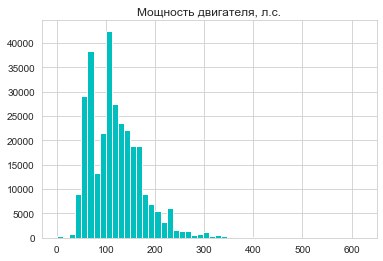

In [47]:
df['Power'].hist(bins=50, color='c')
plt.title('Мощность двигателя, л.с.')
plt.show()

Гистограмма стала гораздо более реалистичной.

**Kilometer**

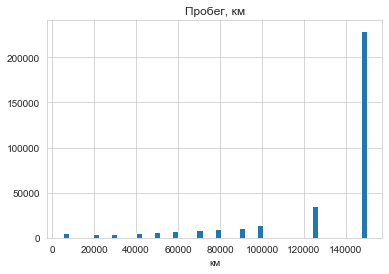

In [48]:
df['Kilometer'].hist(bins=50)
plt.title('Пробег, км')
plt.xlabel('км')
plt.show()

Пробег как-то странно дискретно распределён, но в остальном, вроде бы, всё адекватно

<h3 style="color:DodgerBlue">1.2.2 Категориальные признаки</h3>

**FuelType**

Ранее выяснили, что *petrol* и *gasoline* - это одно и то же, просто на разных площадках бензин назван разными терминами. Вроде бы можно заменить, но есть сомнения. Проверю, что с ценами на эти авто.

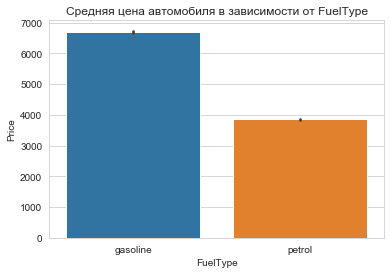

In [49]:
sns.barplot(x='FuelType', y='Price', 
                data = df[df['FuelType'].isin(['petrol', 'gasoline'])].sample(frac=0.5, random_state = 27))
plt.title(f'Средняя цена автомобиля в зависимости от FuelType')
plt.show()

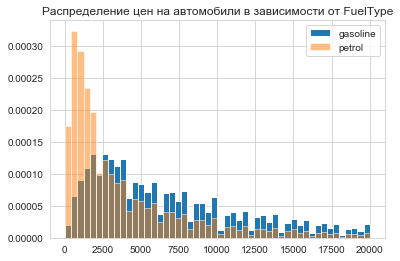

In [50]:
plt.hist(df.loc[df.loc[:, 'FuelType'] == 'gasoline', 'Price'], bins=50, label='gasoline', density=True)
plt.hist(df.loc[df.loc[:, 'FuelType'] == 'petrol', 'Price'], bins=50, label='petrol', density=True, alpha=0.5)
plt.legend()
plt.title(f'Распределение цен на автомобили в зависимости от FuelType')
plt.show()

Хвосты распределений похожи, а вот у с 'petrol' гораздо больше дешёвых машин. Из другого региона? Непонятно, этот вопрос обязательно нужно было бы выяснить при выполнении реальной задачи. Оставлю всё как есть, объединять категории не буду.

**Brand**

In [51]:
print(df['Brand'].unique())

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'alfa_romeo' 'subaru' 'volvo' 'mitsubishi' 'kia'
 'suzuki' 'lancia' 'sonstige_autos' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'chrysler' 'jaguar' 'daewoo' 'rover' 'porsche'
 'saab' 'land_rover' 'lada']


Подозрительный бренд rover. В принципе, был такой бренд, [с 2005 года он не существует](https://ru.wikipedia.org/wiki/Rover_Company). Посмотрим, какие модели ему соответствуют:

In [52]:
df.loc[df.Brand == 'rover', 'Model'].unique()

array(['other', 'discovery', nan, 'rangerover', 'freelander', 'defender'],
      dtype=object)

Это не [модели Rover](https://www.drive2.ru/cars/rover/). Это land_rover. По крайней мере 'discovery', 'rangerover', 'freelander', 'defender'. Заменю сразу.

In [53]:
df.loc[(df.Brand == 'rover') 
       & (df.Model.isin(['discovery', 'rangerover', 'freelander', 'defender'])), 
       'Brand'] = 'land_rover'

In [54]:
df.loc[df.Brand == 'rover', 'Model'].unique()

array(['other', nan], dtype=object)

Теперь проверю, что это за оставшиеся авто

In [55]:
print('rover младше 2005:', df.loc[(df.Brand == 'rover') & (df.RegistrationYear > 2005), :].shape[0], 'шт.')

df.loc[(df.Brand == 'rover') & (df.RegistrationYear > 2005), :]

rover младше 2005: 12 шт.


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode
10487,1350,sedan,2006.0,manual,80.0,other,150000,1.0,petrol,rover,NaN,2016-03-31,79110
47396,4000,convertible,2006.0,manual,136.0,other,150000,4.0,petrol,rover,no,2016-04-01,29525
56188,600,NaN,2016.0,manual,177.0,other,150000,NaN,petrol,rover,no,2016-03-10,44577
128266,100,NaN,2016.0,manual,NaN,other,20000,NaN,petrol,rover,yes,2016-03-17,82008
139110,550,NaN,2016.0,manual,NaN,NaN,150000,NaN,petrol,rover,NaN,2016-03-27,1169
149373,400,NaN,2016.0,manual,75.0,NaN,80000,NaN,petrol,rover,NaN,2016-03-19,33604
151981,1800,NaN,2016.0,manual,106.0,NaN,150000,NaN,gasoline,rover,no,2016-03-21,21776
169033,400,NaN,2016.0,manual,75.0,NaN,80000,NaN,petrol,rover,NaN,2016-03-06,33604
224606,799,NaN,2016.0,manual,75.0,other,150000,3.0,petrol,rover,no,2016-03-20,97424
256516,1550,sedan,2006.0,manual,80.0,other,150000,1.0,petrol,rover,NaN,2016-03-26,79110


12 rover младше 2005 года. Объектов мало, они сомнительные, могут быть и land_rover, а могут и не быть. Удалю.

In [56]:
df.drop(index=df[(df.Brand == 'rover') & (df.RegistrationYear > 2005)].index, inplace=True)

In [57]:
df.loc[df.Brand == 'rover', :].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode
908,2500,wagon,2001.0,auto,150.0,other,150000,11.0,petrol,rover,yes,2016-04-06,56170
1190,249,small,1998.0,manual,75.0,other,150000,9.0,petrol,rover,yes,2016-03-13,41564
1328,700,sedan,1998.0,manual,75.0,other,150000,6.0,petrol,rover,no,2016-03-22,38829
2334,180,sedan,1996.0,manual,110.0,other,150000,6.0,petrol,rover,yes,2016-04-04,27211
2787,2499,sedan,2000.0,manual,116.0,other,150000,5.0,gasoline,rover,no,2016-03-14,49090


In [58]:
df.loc[df.Brand == 'rover', 'VehicleType'].describe()

count       386
unique        7
top       sedan
freq        210
Name: VehicleType, dtype: object

In [59]:
df.loc[(df.Brand == 'rover') & (df.VehicleType == 'suv'), 'VehicleType'].count()

0

Осталось небольшое количество автомобилей с неизвестными моделями. В основном в кузове "седан". В кузове 'suv' нет ни одного. Сравню с аналогичными 'land_rover'

In [60]:
df.loc[(df.Brand == 'land_rover') 
       & (df.Model.isin(['other', np.nan])), 
       :]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode
4250,3200,suv,2002.0,auto,111.0,NaN,150000,5.0,gasoline,land_rover,yes,2016-03-27,59348
21430,1200,sedan,1998.0,manual,77.0,other,100000,4.0,gasoline,land_rover,no,2016-03-12,89250
38067,8450,suv,1966.0,manual,63.0,other,60000,9.0,gasoline,land_rover,no,2016-03-22,65326
57088,12500,suv,1975.0,manual,69.0,other,70000,12.0,petrol,land_rover,no,2016-03-15,24960
72643,4000,suv,1986.0,manual,90.0,other,150000,12.0,lpg,land_rover,no,2016-03-12,79856
75238,6300,suv,1973.0,manual,69.0,other,70000,11.0,NaN,land_rover,no,2016-03-10,33813
102031,11900,NaN,NaN,manual,NaN,NaN,150000,NaN,NaN,land_rover,no,2016-03-22,47661
113997,9600,suv,1970.0,NaN,NaN,other,5000,NaN,NaN,land_rover,NaN,2016-03-26,4509
138623,4950,suv,1979.0,NaN,63.0,other,100000,3.0,gasoline,land_rover,no,2016-03-13,63150
145358,7500,suv,1984.0,manual,61.0,other,100000,3.0,gasoline,land_rover,no,2016-03-21,13355


А вот неизвестные land_rover в основном suv. Буду считать, что разделил автомобили по брендам верно.

**Model**

Проверю модели на скрытые дубли (наприм a6 и a_6)

In [61]:
print(df['Model'].unique())

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva'
 'arosa' 'other' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8'
 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'corsa' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

Всё в порядке.

К остальным категориальным признакам по скрытым дублям и аномалиям на основании предварительного анализа вопросов не было, всё в порядке.

Вообще, в данной работе можно достаточно серьёзно улучшить качество входных данных, но это требует существенного времени и находится вне задачи учебного проекта. Часть данных можно найти/спарсить в открытых источниках (например, модельные ряды брендов, линейки двигателей для них, когда они выпускались и т.д.) И на основании этих данных исправить данные/заполнить пропуски.

Также, например, видно, что некоторые модели брендов указаны в разных кузовах, но преобладает один тип. Это может быть следствием ошибок при заполнении анкет. Например, wagon и bus, suv и wagon могут быть спутаны. Или седан и купе. Можно проводить отдельный анализ, поднять данные, в какие годы в каком кузове авто данной марки выпускались и исправить ошибки. Можно и просто заполнить самым частым значением, но это очень грубо. Т.к., в теории, модель может выпускаться, например, в кузове купе и в кузове convertible (допустим, с откидной крышей).

<h1 style="color:SteelBlue"> 2. Обработка пропусков: Pipeline и функциональная подготовка</h1>

<h2 style="color:DodgerBlue">2.1 Введение</h2>

После очистки данных явных пропусков стало больше. Некоторые некорректные значения, а также нулевые значения, которые, по сути, являются пропусками, я заполнил явными NaN.

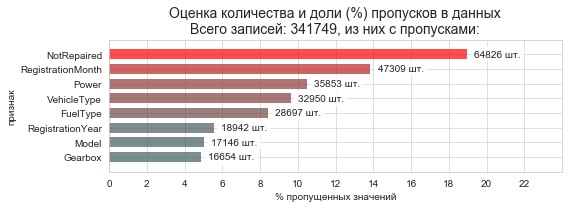

In [62]:
nan_estimation_graph(df)

Можно пропуски попробовать заполнить на основании других данных объекта. Допустим, по сочетанию *модель-бренд-год выпуска* определить наиболее подходящий тип кузова. Это, на мой взгляд, позволит вполне достоверно восстановить его. 

**Для того, чтобы сделать такое заполнение написал класс <code>DictionaryImputer</code>. (код - в начале тетрадки) Для каждого набора значений заданных в <code>predict</code> признаков он:**

*Обучается(<code>fit</code>):* По тестовой выборке подбирает для целевого <code>target</code> признака самое частое/среднее/медианное значение, соответствующее заданной комбинации других признаков(<code>predictors</code>), создаёт словарь вида <code>{кортеж значений predictors: значение target}</code>

*Преобразует набор данных(<code>transform</code>):* Заполняет NaN в целевом признаке согласно словарю, полученному на этапе *fit.*

Можно поробовать заполнить тип топлива в зависимости от бренда, модели, кузова и мощности авто (обычно двигатели с разным типом топлива отличаются по мощности, и каждой модели авто соответствует линейка двигателей определённой мощности). Скорее всего, это в основном будет бензин, но вдруг получится выявить редкие типы топлива

В принципе, можно вообще сделать итерационное заполнение. Например, по бренд-модель-год регистрации заполнить кузов, по бренд-модель-кузов - год регистрации и т.д. Можно библиотечный IterativeImputer также попробовать. Однако мы ограничены временем и перечнем задач по проекту.

Другие возможные варианты:

- для регрессионной модели заполнять средними и самыми частыми значениями по выборке/по группам (бренд-модель, например)

- для XGBoost заполнить пропуски, например, числом -1000 и категорией "unknown". Также можно попробовать вариант, как для регрессии 

- LightGBM работает с NaN. Для него вообще ничего не заполнять, либо заполнить аналогично предыдущим.
- Для CatBoost NaN в категориях заполнить нехарактерными значениями, числовые признаки не заполнять. Либо как в предыдущих вариантах

Написал 2 класса для заполнения и кодирования, далее разберём их и проверим.

<h2 style="color:DodgerBlue">2.2 Проверка работоспособности классов</h2>

<h3 style="color:DodgerBlue">2.2.1 DictionaryImputer</h3>

*Обучается(<code>fit</code>):* По тестовой выборке подбирает для целевого <code>target</code> признака самое частое/среднее/медианное значение, соответствующее заданной комбинации других признаков(<code>predictors</code>), создаёт словарь вида <code>{кортеж значений predictors: значение target}</code>

*Преобразует набор данных(<code>transform</code>):* Заполняет NaN в целевом признаке согласно словарю, полученному на этапе fit.

In [63]:
#DictionaryImputer test
vehicletype_imputer = DictionaryImputer(['Brand', 'Model'], 'VehicleType')
fueltype_imputer = DictionaryImputer(['Brand', 'Model', 'Power'], 'FuelType')

X_class = df.drop(columns=['Price']).sample(10000)
y_class = df.loc[X_class.index, 'Price']

print('DictionaryImputer: VehicleType')
print('NaN before', X_class['VehicleType'].isna().sum())
start = datetime.now()
vehicletype_imputer.fit_transform(X_class)
end = datetime.now()
print('NaN after', X_class['VehicleType'].isna().sum())
print('time eplaced:', end-start)
print('\nDictionaryImputer: FuelType')
print('NaN before', X_class['FuelType'].isna().sum())
start = datetime.now()
fueltype_imputer.fit_transform(X_class)
end = datetime.now()
print('NaN after', X_class['FuelType'].isna().sum())
print('time eplaced:', end-start)

DictionaryImputer: VehicleType
NaN before 990
NaN after 173
time eplaced: 0:00:00.084688

DictionaryImputer: FuelType
NaN before 840
NaN after 447
time eplaced: 0:00:00.447959


In [64]:
vehicletype_imputer = DictionaryImputer(['Brand', 'Model'], 'VehicleType')
fueltype_imputer = DictionaryImputer(['Brand', 'Model', 'Power'], 'FuelType')

#DictionaryImputer test in pipeline and gridsearch
X_class = df.drop(columns=['Price']).sample(10000)
y_class = df.loc[X_class.index, 'Price']

pipeline = Pipeline(steps = [('vehicletype_imputer', vehicletype_imputer),
                             ('fueltype_imputer', fueltype_imputer),
                             ('model', DummyRegressor())])

gs = GridSearchCV(pipeline, {'model__strategy':['mean', 'median']}, 
                  scoring='neg_root_mean_squared_error', cv=2, verbose=1)
display(gs.fit(X_class, y_class))
display(pd.DataFrame(gs.cv_results_))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vehicletype_imputer',
                                        DictionaryImputer(predictors=['Brand',
                                                                      'Model'],
                                                          target='VehicleType')),
                                       ('fueltype_imputer',
                                        DictionaryImputer(predictors=['Brand',
                                                                      'Model',
                                                                      'Power'],
                                                          target='FuelType')),
                                       ('model', DummyRegressor())]),
             param_grid={'model__strategy': ['mean', 'median']},
             scoring='neg_root_mean_squared_error', verbose=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__strategy,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.371328,0.013693,0.035924,0.004654,mean,{'model__strategy': 'mean'},-4493.896636,-4522.797449,-4508.347043,14.450407,1
1,0.357221,0.007910,0.035982,0.002274,median,{'model__strategy': 'median'},-4814.212850,-4809.522557,-4811.867704,2.345147,2


In [65]:
X_class = df.drop(columns=['Price']).sample(10000)
y_class = df.loc[X_class.index, 'Price']

print('pipline DictionaryImputer: VehicleType -> FuelType -> model: DummyRegressor')
print('NaN VehicleType before', X_class['VehicleType'].isna().sum())
print('NaN FuelType before', X_class['FuelType'].isna().sum())
pipeline.fit(X_class, y_class)
print('NaN VehicleType after', X_class['VehicleType'].isna().sum())
print('NaN FuelType after', X_class['FuelType'].isna().sum())
print('Dummy prediction:')
pipeline.predict(X_class)

pipline DictionaryImputer: VehicleType -> FuelType -> model: DummyRegressor
NaN VehicleType before 958
NaN FuelType before 845
NaN VehicleType after 152
NaN FuelType after 451
Dummy prediction:


array([4591.1365, 4591.1365, 4591.1365, ..., 4591.1365, 4591.1365,
       4591.1365])

<h3 style="color:DodgerBlue">2.2.2 DictionaryEncoder</h3>

Составляет словарь из названий категорий кодируемого признака и и соответствующего значения средней цены авто для каждой категории. Средняя цена считается по трейну, утечки тут нет. Далее заменяет категорию на значение из словаря. Если в словаре отсутствует категория, заменяет на среднюю цену авто в трейне.

In [66]:
#DictionaryEncoder test
model_encoder = DictionaryEncoder('Price', 'Model')
postal_code_encoder = DictionaryEncoder('Price', 'PostalCode', is_model=False)

X_class = df.drop(columns=['Price']).sample(10000)
y_class = df.loc[X_class.index, 'Price']

print('DictionaryEncoder: Model')
print('before')
display(X_class['Model'].head())
start = datetime.now()
model_encoder.fit_transform(X_class, y_class)
end = datetime.now()
print('after')
display(X_class['Model'].head())
display(X_class['Model'].describe())
print('time eplaced:', end-start)

print('\nDictionaryEncoder: PostalCode')
print('before')
display(X_class['PostalCode'].head())
start = datetime.now()
postal_code_encoder.fit_transform(X_class, y_class)
end = datetime.now()
print('after')
display(X_class['PostalCode'].head())
display(X_class['PostalCode'].describe())
print('time eplaced:', end-start)

DictionaryEncoder: Model
before


3322         clio
217744    transit
202495        3er
283070      modus
150631      arosa
Name: Model, dtype: object

after


3322     -1.016986
217744   -0.077898
202495    0.120893
283070   -0.675450
150631   -1.321819
Name: Model, dtype: float64

count    1.000000e+04
mean     1.197487e-15
std      1.000000e+00
min     -1.703658e+00
25%     -7.335853e-01
50%     -1.367873e-01
75%      4.442122e-01
max      5.058647e+00
Name: Model, dtype: float64

time eplaced: 0:00:00.253961

DictionaryEncoder: PostalCode
before


3322      50259
217744    12101
202495    63065
283070    64807
150631    56410
Name: PostalCode, dtype: int64

after


3322      0.277079
217744   -1.007502
202495    1.395295
283070    1.561445
150631   -0.101088
Name: PostalCode, dtype: float64

count    1.000000e+04
mean     1.809108e-15
std      1.000000e+00
min     -1.468626e+00
25%     -7.124220e-01
50%     -2.072135e-01
75%      4.851957e-01
max      4.951062e+00
Name: PostalCode, dtype: float64

time eplaced: 0:00:00.169350


In [67]:
#DictionaryEncoder test in pipeline and gridsearch

X_class = df.drop(columns=['Price']).sample(10000)
y_class = df.loc[X_class.index, 'Price']

pipeline = Pipeline(steps = [('model_encoder', model_encoder),
                             ('postal_code_encoder', postal_code_encoder),
                             ('model', DummyRegressor())])

gs = GridSearchCV(pipeline, {'model__strategy':['mean', 'median']}, 
                  scoring='neg_root_mean_squared_error', cv=2, verbose=1)

display(gs.fit(X_class, y_class))
display(pd.DataFrame(gs.cv_results_))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s finished


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model_encoder',
                                        <__main__.DictionaryEncoder object at 0x000001DCA44F5888>),
                                       ('postal_code_encoder',
                                        <__main__.DictionaryEncoder object at 0x000001DCA44F59C8>),
                                       ('model', DummyRegressor())]),
             param_grid={'model__strategy': ['mean', 'median']},
             scoring='neg_root_mean_squared_error', verbose=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__strategy,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.231799,0.031247,0.203920,0.003394,mean,{'model__strategy': 'mean'},-4536.558166,-4512.256191,-4524.407178,12.150988,1
1,0.212610,0.000911,0.201719,0.000240,median,{'model__strategy': 'median'},-4811.177100,-4849.217194,-4830.197147,19.020047,2


Классы работают как отдельно, так и в <code>pipeline</code> <code>gridsearch</code>

Собираюсь придерживаться следующей тактики: 
- на этапе выбора модели для прогноза заполнить NotRepaired модой по выборке (чтобы не терять из-за одного этого признака объекты), заполнить VehicleType (на основании бренд-модель-год) и FuelType (на основании бренд-модель-год-мощность)
- дропнуть все прочие объекты с NaN; 
- подобрать оптимальную по *времени работы и значению метрики* модель на этих данных
- "вернуть" объекты с пропусками и, попробовать разные варианты предобработки (кодирование, заполнение пропусков, стандартизация) для выбранной модели. подобрать лучшие варианты
- настроить гиперпараметры
- подготовить итоговый пайплайн

<h1 style="color:SteelBlue"> 3. Feature engineering</h1>

**Возраст автомобиля**

В данных есть год и месяц регистрации ТС и дата подачи объявления о продаже. Вычтя одно из другого, можно получить возраст автомобиля в месяцах. Также можно посчитать разницы годов. При небольшом возрасте авто это не будет точным возрастом в годах, но позволит сказать, прошлого года это авто, или текущего, например. Попробую создать оба признака и проанализировать зависимости. Признаки <code>'DateCreated', 'RegistrationYear', 'RegistrationMonth'</code> после этого не понадобятся. Т.к. все объявления, в основном, поданы в пределах 1-2х месяцев (в сжатый отрезок времени), необходимости в разбиении выборки для теста и валидации методом <code>TimeSeriesSplit</code> нет.

In [68]:
df.loc[:, 'age_in_years'] = df['DateCreated'].dt.year - df['RegistrationYear']
df.loc[:, 'age_in_months'] = (df['DateCreated'].dt.month - df['RegistrationMonth']) + 12*df['age_in_years']

In [69]:
df.drop(columns=['DateCreated', 'RegistrationYear', 'RegistrationMonth'], inplace=True)

In [70]:
df.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode,age_in_years,age_in_months
0,480,NaN,manual,NaN,golf,150000,petrol,volkswagen,NaN,70435,23.0,NaN
1,18300,coupe,manual,190.0,NaN,125000,gasoline,audi,yes,66954,5.0,58.0
2,9800,suv,auto,163.0,grand,125000,gasoline,jeep,NaN,90480,12.0,139.0
3,1500,small,manual,75.0,golf,150000,petrol,volkswagen,no,91074,15.0,177.0
4,3600,small,manual,69.0,fabia,90000,gasoline,skoda,no,60437,8.0,92.0


**Место продажи**

PostalCode указывает на место, где продаётся автомобиль. Это признак, по сути, категориальный. Сейчас категорий огромное количество (около 100 тыс.). Такая точность, которую предоставляет почтовый код, скорее всего, не нужна. 

Большая часть почтовых кодов в данных представлена, судя по всему, Германией.  Cистема почтовой индексации современной Германии предусматривает деление территории страны на десять главных почтовых зон и использование пятизначных цифровых кодов. [wikipedia](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%87%D1%82%D0%BE%D0%B2%D1%8B%D0%B5_%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D1%8B_%D0%B2_%D0%93%D0%B5%D1%80%D0%BC%D0%B0%D0%BD%D0%B8%D0%B8)

Первая (крайняя левая) цифра в PLZ-коде обозначает зону (Zone) и, соответственно, аэропорт, через который происходит обмен почтой с этой зоной. При этом следует понимать, что зональное деление PLZ-кодов не соответствует административному делению Германии на земли.

Вторая цифра в PLZ-коде обозначает регион зоны и вместе с номером зоны образует двузначный номер региона, который определяет дальнейшую маршрутизацию почты внутри зоны. 

Судя по [карте почтовых зон](https://en.wikipedia.org/wiki/List_of_postal_codes_in_Germany), первых двух цифр индекса вполне достаточно для локализации места продажи. При этом мы не потеряем в точности, но значительно сократим количество локаций.

Создам такой признак. Назову <code>post_zone_region</code> и <code>post_zone</code>. <code>PostalCode</code> удалю, т.к. он явно избыточен для моделей по числу категорий.

In [71]:
df.loc[:, 'post_zone_region'] = (df['PostalCode']/1000).astype(int)
df.drop(columns=['PostalCode'], inplace=True)

In [72]:
df.loc[:, 'post_zone'] = (df['post_zone_region']/10).astype(int)

In [73]:
df.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,age_in_years,age_in_months,post_zone_region,post_zone
0,480,NaN,manual,NaN,golf,150000,petrol,volkswagen,NaN,23.0,NaN,70,7
1,18300,coupe,manual,190.0,NaN,125000,gasoline,audi,yes,5.0,58.0,66,6
2,9800,suv,auto,163.0,grand,125000,gasoline,jeep,NaN,12.0,139.0,90,9
3,1500,small,manual,75.0,golf,150000,petrol,volkswagen,no,15.0,177.0,91,9
4,3600,small,manual,69.0,fabia,90000,gasoline,skoda,no,8.0,92.0,60,6


<h1 style="color:SteelBlue">4. Исследовательский анализ данных</h1>

Посмотрим, есть ли связь цены с созданными на предыдущем этапе признаками. Анализ буду проводить на выборке из полного датасета, чтобы сократить время построения графиков.

**'age_in_years' и 'age_in_months'**

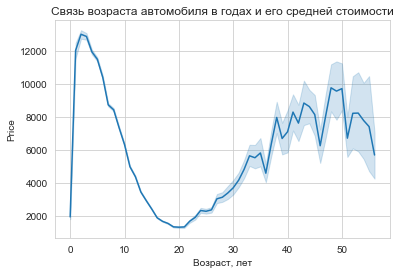

In [74]:
sns.lineplot(x = 'age_in_years', y='Price', data=df.sample(frac=0.5, random_state = 27))
plt.title('Связь возраста автомобиля в годах и его средней стоимости')
plt.xlabel('Возраст, лет')
plt.show()

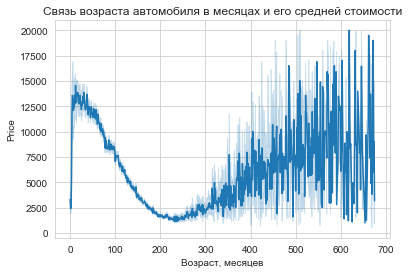

In [75]:
sns.lineplot(x = 'age_in_months', y='Price', data=df.sample(frac=0.3, random_state = 27))
plt.title('Связь возраста автомобиля в месяцах и его средней стоимости')
plt.xlabel('Возраст, месяцев')
plt.show()

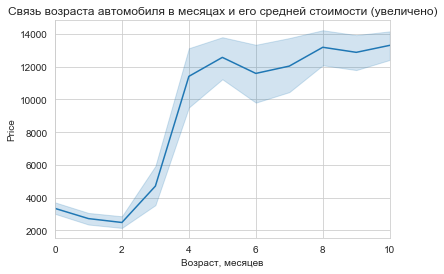

In [76]:
sns.lineplot(x = 'age_in_months', y='Price', data=df[df['age_in_months'] <= 10])
plt.title('Связь возраста автомобиля в месяцах и его средней стоимости (увеличено)')
plt.xlabel('Возраст, месяцев')
plt.xlim(0,10)
plt.show()

Вполне логичная картина за исключением того, что автомобили малого возраста (<4 месяцев и младше 1 года (это не одно и то же, т.к. есть пропуски признаков)) в среднем очень дешёвые. Также в автомобилях большого возраста (по месяцам) заметен сильный разброс. Видимо, там много ошибочных объектов. 
Проверю подробнее новые автомобили (почему такие дешёвые).

In [77]:
df.loc[df['age_in_years'] == 0, 'Price'].describe()

count     3957.000000
mean      2026.231741
std       3147.662107
min         50.000000
25%        450.000000
50%        850.000000
75%       2000.000000
max      20000.000000
Name: Price, dtype: float64

In [78]:
df.loc[df['age_in_years'] == 0, :].head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,age_in_years,age_in_months,post_zone_region,post_zone
16,300,NaN,NaN,60.0,polo,150000,petrol,volkswagen,NaN,0.0,NaN,38,3
37,1500,NaN,NaN,NaN,kangoo,150000,gasoline,renault,no,0.0,2.0,46,4
52,1400,NaN,manual,55.0,other,5000,NaN,hyundai,NaN,0.0,3.0,34,3
79,150,NaN,manual,75.0,astra,150000,petrol,opel,yes,0.0,0.0,78,7
181,3000,NaN,auto,75.0,fabia,150000,petrol,skoda,NaN,0.0,NaN,24,2


In [79]:
df.loc[df['age_in_years'] == 0, 'Kilometer'].describe()

count      3957.000000
mean     132979.529947
std       39537.810492
min        5000.000000
25%      150000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [80]:
df.loc[df['age_in_years'] == 1, 'Kilometer'].describe()

count      1175.000000
mean      18634.042553
std       23311.508704
min        5000.000000
25%        5000.000000
50%       10000.000000
75%       20000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [81]:
df.loc[df['age_in_years'] == 2, 'Kilometer'].describe()

count      2496.000000
mean      31758.814103
std       22066.839675
min        5000.000000
25%       20000.000000
50%       30000.000000
75%       40000.000000
max      150000.000000
Name: Kilometer, dtype: float64

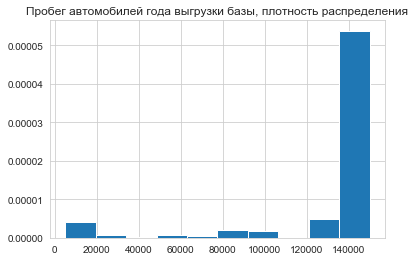

In [82]:
plt.hist(df.loc[df['age_in_years'] == 0, 'Kilometer'], density=True)
plt.title('Пробег автомобилей года выгрузки базы, плотность распределения')
plt.show()

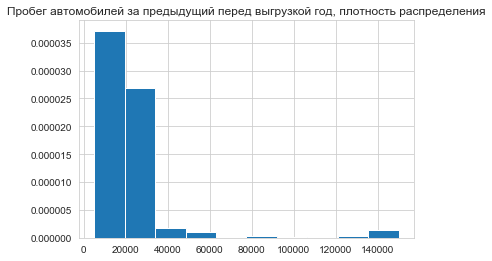

In [83]:
plt.hist(df.loc[df['age_in_years'] == 1, 'Kilometer'], density=True)
plt.title('Пробег автомобилей за предыдущий перед выгрузкой год, плотность распределения')
plt.show()

Какие-то бешеные и подозрительно одинаковые пробеги для авто нулевого возраста. Причём, у авто первого года и далее уже в среднем 19 и 32 тыс, что похоже на правду. При этом [auto.mail.ru](https://auto.mail.ru/article/22789-srednegodovoi_probeg_nemeckogo_avtomobilya_-_13_500_km/) сообщает, что среднегодовой пробег немецкого автомобиля - 13 500 км (что, кстати, согласуется с данными за другие годы по нашему датасету). Учитывая, что std для авто певого и второго годов - 22-23 тыс км, удалю авто первого года с пробегами более чем 13500 + 3x22000 км (примерно 80 000 км). 

In [84]:
df.drop(index = df.loc[(df['age_in_years'] == 0) & (df['Kilometer'] > 80000), 'Kilometer'].index, 
        inplace=True)

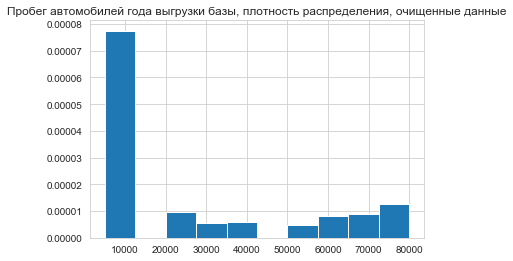

In [85]:
plt.hist(df.loc[df['age_in_years'] == 0, 'Kilometer'], density=True)
plt.title('Пробег автомобилей года выгрузки базы, плотность распределения, очищенные данные')
plt.show()

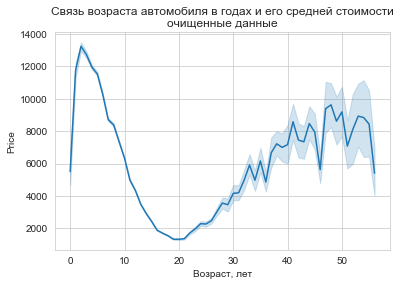

In [86]:
sns.lineplot(x = 'age_in_years', y='Price', data=df.sample(frac=0.5, random_state = 27))
plt.title('Связь возраста автомобиля в годах и его средней стоимости\nочищенные данные')
plt.xlabel('Возраст, лет')
plt.show()

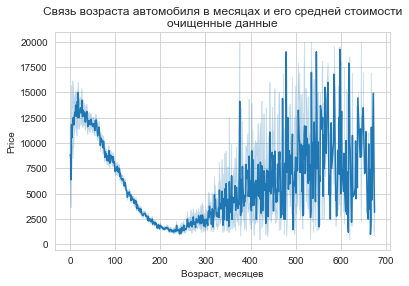

In [87]:
sns.lineplot(x = 'age_in_months', y='Price', data=df.sample(frac=0.3, random_state = 27))
plt.title('Связь возраста автомобиля в месяцах и его средней стоимости\nочищенные данные')
plt.xlabel('Возраст, месяцев')
plt.show()

Стало получше. Посмотрю, сколько данных осталось:

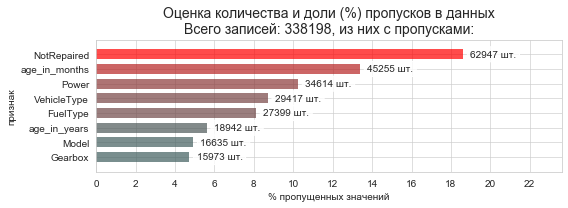

In [88]:
nan_estimation_graph(df)

Около 3000 объектов ещё пришлось удалить.

Видно, что возраст в месяцах - более "шумный" признак, при этом в нём гораздо больше пропусков, чем в 'age_in_years'. Да и при продаже/покупке авто обычно смотрят на год, а не на месяц. Поэтому оставлю только признак <code>'age_in_years'</code>, а <code>'age_in_months'</code> удалю.

In [89]:
df.drop(columns=['age_in_months'], inplace=True)

Итак, из двух признаков <code>'age_in_years'</code> и <code>'age_in_months'</code> выбрал <code>'age_in_years'</code>, как менее шумный, с меньшим количеством пропусков и аналогичной информативностью.

График зависимости средней стоимости авто от возраста показывает, что новые автомобили (за исключением не очень качественных данных за 0й год) в среднем самые дорогие. Затем с ростом возраста наблюдается спад, его минимум - в точке около 20 лет. Затем автомобили начинают дорожать (становятся раритетными и эксклюзивными).

**'post_zone' и 'post_zone_region'**

Рассмотрим связь почтового региона и стоимости авто.

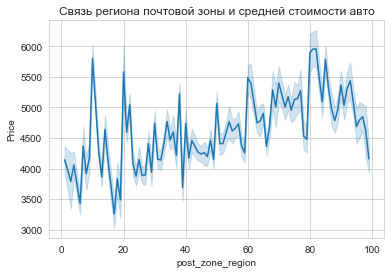

In [90]:
sns.lineplot(x = 'post_zone_region', y='Price', data=df.sample(frac=0.5, random_state = 27))
plt.title('Связь региона почтовой зоны и средней стоимости авто')
plt.xlabel('post_zone_region')
plt.show()

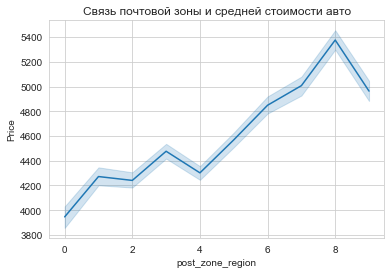

In [91]:
sns.lineplot(x = df['post_zone'], y='Price', data=df.sample(frac=0.5, random_state = 27))
plt.title('Связь почтовой зоны и средней стоимости авто')
plt.xlabel('post_zone_region')
plt.show()

Наблюдается интересная картина. В Германии 10 почтовых зон, от 0 до 9. При этом зоны 0-4 - это север Германии, а 5-9 - это юг. Получается, на юге Германии автомобили в среднем дороже, и эта зависимость чётко видна.

Что касается региона почтовой зоны, то с ним тоже всё хорошо прослеживается. Например, пик на 10 - это Berlin city centre. А 20 - это Hamburg. 40 - Düsseldorf, 50 - Köln, 60 - Frankfurt am Main, 80 - Munich. География цен в цифрах регионов почтовых зон.

Признаки, конечно, коррелируют, но каждый по своему хорош, оставлю пока оба.

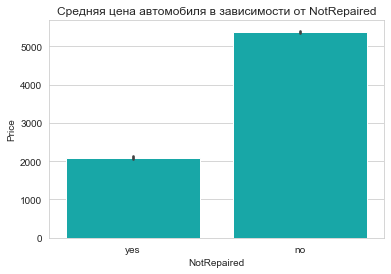

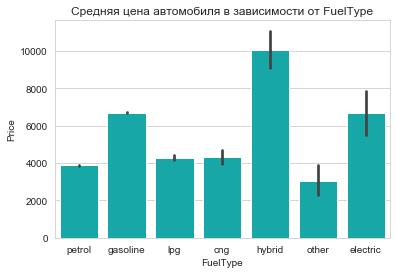

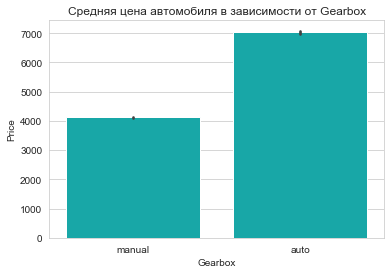

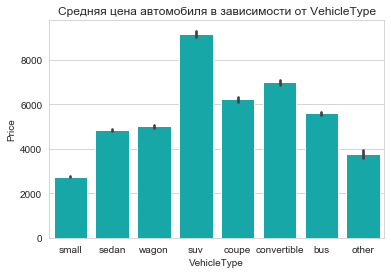

In [92]:
for feature in (set(object_cols) - set(['Model', 'Brand'])):
    sns.barplot(x=feature, y='Price', 
                data = df.sample(frac=0.5, random_state = 27), color = 'c')
    plt.title(f'Средняя цена автомобиля в зависимости от {feature}')
    plt.show()

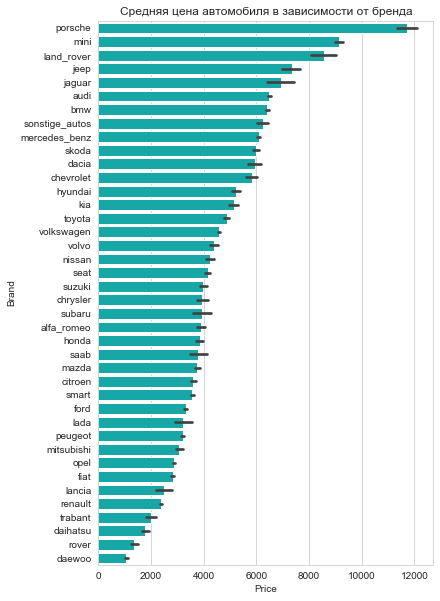

In [93]:
plt.figure(figsize=(6,10))
df.groupby('Brand')['Price'].mean()
sns.barplot(y='Brand', x='Price', data = df, color = 'c',
            order = df.groupby('Brand')['Price'].mean().sort_values(ascending=False).index)
plt.title(f'Средняя цена автомобиля в зависимости от бренда')
plt.show()

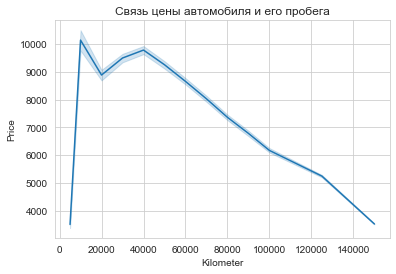

In [94]:
sns.lineplot(x='Kilometer', y='Price', data = df)
plt.title(f'Связь цены автомобиля и его пробега')
plt.show()

Все результаты логичны: коробка автомат в среднем дороже, чем ручная. Машины, не подвергавшиеся ремонту, стоят дороже, чем те, которые ремонтировали. Самые дорогие в среднем кузова - это suv, самые дешёвые - small. Авто с гибридными и электрическими силовыми установками - тоже самые дорогие. Из брендов выделяются porshe, land rover, jaguar, mini, jeep. Самые дешёвые - daewoo, rover, daihatsu.

Ну и чем выше пробег, тем ниже цена. По прежнему какие-то проблемы с автомобилями с малым пробегом. Видимо, это ошибки ещё тянутся, связанные с мусорными данными первого года. Либо только что купленные автомобили продают в случае дтп или плохого состояния, тогда всё объяснимо. Например, это автомобили с малым пробегом, но после ДТП.

В целом, все зависимости логичны, объяснимы. Они вполне явные. Можно ожидать успешного построения моделей.

<h1 style="color:SteelBlue">5. Машинное обучение</h1>

После всех проведённых операций с данными, имеем следующую картину:

In [95]:
df.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,age_in_years,post_zone_region,post_zone
0,480,NaN,manual,NaN,golf,150000,petrol,volkswagen,NaN,23.0,70,7
1,18300,coupe,manual,190.0,NaN,125000,gasoline,audi,yes,5.0,66,6
2,9800,suv,auto,163.0,grand,125000,gasoline,jeep,NaN,12.0,90,9
3,1500,small,manual,75.0,golf,150000,petrol,volkswagen,no,15.0,91,9
4,3600,small,manual,69.0,fabia,90000,gasoline,skoda,no,8.0,60,6


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338198 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             338198 non-null  int64  
 1   VehicleType       308781 non-null  object 
 2   Gearbox           322225 non-null  object 
 3   Power             303584 non-null  float64
 4   Model             321563 non-null  object 
 5   Kilometer         338198 non-null  int64  
 6   FuelType          310799 non-null  object 
 7   Brand             338198 non-null  object 
 8   NotRepaired       275251 non-null  object 
 9   age_in_years      319256 non-null  float64
 10  post_zone_region  338198 non-null  int32  
 11  post_zone         338198 non-null  int32  
dtypes: float64(2), int32(2), int64(2), object(6)
memory usage: 41.0+ MB


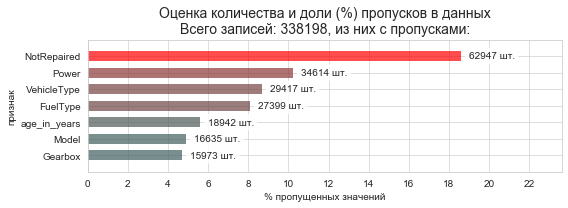

In [97]:
nan_estimation_graph(df)

Ещё раз обозначим тактику действий: 

- заполнить NotRepaired модой по выборке (чтобы не терять из-за одного этого признака объекты), заполнить VehicleType (на основании бренд-модель) и FuelType (на основании бренд-модель-год-мощность)
- дропнуть все прочие объекты с NaN; 
- подобрать оптимальную по *времени работы и значению метрики* модель на этих данных
- "вернуть" объекты с пропусками, подобрать лучший вариант предобработки данных
- настроить гиперпараметры
- подготовить итоговый пайплайн

<h2 style="color:DodgerBlue">5.0 Train-test split, DummyRegressor</h2>

In [98]:
X = df.drop('Price', axis=1)
y = df.loc[X.index, 'Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

Перед началом подбора моделей рассчитаю метрику для <code>DummyRegressor</code>.

In [99]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
dummy_predictions = dummy.predict(X_test)
print('Dummy predictons (mean strategy) rmse:', np.sqrt(mean_squared_error(y_test, dummy_predictions)))

Dummy predictons (mean strategy) rmse: 4507.342905894655


<h2 style="color:DodgerBlue">5.1 Выбор модели</h2>

Подготовлю функцию для кросс-валидации (сперва хотел всё обернуть в sklearn pipeline и использовать с ним GridSearchCV, но, из-за того, что нужно дропнуть NaN после заполнения пропусков, пришлось обернуть в свою функцию; sklearn API [не позволяет написать трансформер, который меняет одновременно X и y](https://sklearn-template.readthedocs.io/en/latest/user_guide.html#transformer), а это нужно для дропа)

In [100]:
cross_validator = KFold(n_splits=5, shuffle=True, random_state=27)

vehicletype_imputer = DictionaryImputer(['Brand', 'Model'], 'VehicleType')

fueltype_imputer = DictionaryImputer(['Brand', 'Model', 'Power'], 'FuelType')

model_encoder = DictionaryEncoder('Price', 'Model')

post_region_encoder = DictionaryEncoder('Price', 'post_zone_region', is_model=False)

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

scaler = StandardScaler()

<h3 style="color:DodgerBlue">5.1.1 Линейная регрессия</h3>

<h3 style="color:DodgerBlue">LinearRegression</h3>

In [101]:
linreg = LinearRegression()

In [102]:
# Получение списка строковых признаков
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print('object columns:', object_cols)

object columns: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']


In [103]:
#в категориальных не только строковые, но и числовые признаки
#выделяю списки для кодирования и стандартизации
num_cols = ['Power', 'Kilometer']
cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'post_zone', 'post_zone_region']

Начну с обучения простой линейной регрессии. 

Пайплайн для неё (и в принципе основной пайплайн) будет такой: 
- заполнение NaN признака NotRepaired модой 
- заполнение vehicletype и fueltype модой по группам признаков - DictImputer()
- кодирование модели и почтового региона - DictEncoder()
- удаление оставшихся объектов с NaN - pandas.dropna()
- кодирование OHE оставшихся категориальных признаков - OneHotEncoder()
- стандартизация количественных признаков - StandardScaler()

Далее 2 функции: pipeline и кросс-валидация на этом пайплайне. На родном Pipeline от Sklearn не удалось реализовать все шаги. К тому же, мне нужна была оценка времени

In [104]:
def base_pipeline(model, X_train, y_train, X_valid, y_valid, 
                  var='base', lgbm = False, steps = []):
    #элементы list:
    #1. заполнение NotRepaired модой
    #2. заполнение vehicletype и fueltype модой по группам признаков DictImputer
    #3. кодирование модели и почтового региона DictEncoder
    #4. удаление оставшихся объектов с NaN
    #5. кодирование OHE
    #6. стандартизация
    #7. преобразование типа category    
    
    X_train, y_train, X_valid, y_valid = X_train.copy(), y_train.copy(), X_valid.copy(), y_valid.copy()
    
    ohe_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'post_zone']
    num_cols = ['Power', 'Kilometer']
    cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'post_zone', 'post_zone_region']
 
    if var == 'base':
        steps = [1, 2, 3, 4, 5, 6]
    
    elif var == 'var_2':
        steps = [1, 2, 4, 6]
        if lgbm:
            cat_cols = cat_cols
            steps.append(7)
    
    elif var =='var_3':
        steps = [1, 2, 3, 4, 6]
        if lgbm:
            cat_cols = list(set(cat_cols) - set(['Model', 'post_zone_region']))
            steps.append(7)
            
    elif var == 'empty':
        pass

    #preprocessing start
    start = datetime.now()
        
    #1. заполнение NotRepaired модой
    if 1 in steps:
        X_train.loc[X_train['NotRepaired'].isna(), 'NotRepaired'] = X_train['NotRepaired'].mode()
        X_valid.loc[X_valid['NotRepaired'].isna(), 'NotRepaired'] = X_train['NotRepaired'].mode()

    #2. заполнение vehicletype и fueltype модой по группам признаков DictImputer
    if 2 in steps:
        vehicletype_imputer.fit_transform(X_train, y_train)
        vehicletype_imputer.transform(X_valid)
        fueltype_imputer.fit_transform(X_train, y_train)
        fueltype_imputer.transform(X_valid)

    #3. кодирование модели и почтового региона DictEncoder
    if 3 in steps:
        model_encoder.fit_transform(X_train, y_train)
        model_encoder.transform(X_valid)    
        post_region_encoder.fit_transform(X_train, y_train)
        post_region_encoder.transform(X_valid)

    #4. удаление оставшихся объектов с NaN
    if 4 in steps:
        X_train.dropna(inplace=True)
        y_train = y_train[X_train.index]
        X_valid.dropna(inplace=True)
        y_valid = y_valid[X_valid.index]

    #5. кодирование OHE
    if 5 in steps:
        OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[ohe_cols]))
        OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[ohe_cols]))
        OH_cols_train.index = X_train.index
        OH_cols_valid.index = X_valid.index
        X_train.drop(columns=ohe_cols, inplace=True)
        X_valid.drop(columns=ohe_cols, inplace=True)
        X_train = pd.concat([X_train, OH_cols_train], axis=1)
        X_valid = pd.concat([X_valid, OH_cols_valid], axis=1)

    #6. стандартизация
    if 6 in steps:
        X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
        X_valid[num_cols] = scaler.transform(X_valid[num_cols])
        
    #7. преобразование типа category
    if lgbm or (7 in steps):
        X_train[cat_cols] = X_train[cat_cols].astype('category')
        X_valid[cat_cols] = X_valid[cat_cols].astype('category')
             
    end = datetime.now()
    #preprocessing finish
    preprocessing_time = end-start
    
    #model fit
    start = datetime.now()
    model.fit(X_train, y_train)
    end = datetime.now()
    fit_time = end-start
    
    #model validation
    start = datetime.now()
    y_valid_predicted = model.predict(X_valid)
    end = datetime.now()
    predict_time = end-start
    
    #metric calculation
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_predicted))
    result = namedtuple('results', ('rmse', 'preprocessing_time', 'fit_time', 'predict_time'))
    
    return result(rmse, preprocessing_time, fit_time, predict_time)

In [105]:
def my_cross_validation(model, pipeline, cross_validator, X_train, y_train, 
                        verbose=True, var='base', lgbm = False, steps = []):
    cv_results_list = []

    for cv_train_index, cv_valid_index in cross_validator.split(X_train):
        X_train_cv = X_train.iloc[cv_train_index].copy()
        y_train_cv = y_train.iloc[cv_train_index].copy()
        X_valid_cv = X_train.iloc[cv_valid_index].copy()
        y_valid_cv = y_train.iloc[cv_valid_index].copy()
        cv_results = pipeline(model, X_train_cv, y_train_cv, X_valid_cv, y_valid_cv, 
                              var=var, lgbm = lgbm, steps=steps)
        cv_results_list.append(cv_results)
        if verbose:
            print(cv_results)
    
    cv_results_df = pd.DataFrame(cv_results_list)
    cv_results_df.loc[:, 'total_time'] = cv_results_df.iloc[:, 1:3].sum(axis=1)
    cv_results_df.loc['mean', :] = cv_results_df.mean()
    
    return cv_results_df     

Для ускорения прогона тетрадки (мнго ресурсов потребляет заполнение и кодирование по словарям) кросс-валидацию моделей буду делать на случайной выборке из всего набора данных. Средние результаты получаются близки к прогону на полных данных. Для отбора модели этого, наверное, достаточно. При необходимости можно изменить <code>fraction</code> при проверке проекта.
Для сравнения оставлю полный прогон линейной регрессии:

In [106]:
fraction=0.2
X_train_frac = X_train.sample(frac=fraction, random_state = 27)
y_train_frac = y_train[X_train_frac.index]

In [107]:
linreg_cv_df_full = my_cross_validation(linreg, base_pipeline, cross_validator, X_train, y_train)

results(rmse=2621.3272462723594, preprocessing_time=datetime.timedelta(seconds=12, microseconds=454321), fit_time=datetime.timedelta(microseconds=343612), predict_time=datetime.timedelta(microseconds=20044))
results(rmse=2637.1624558769054, preprocessing_time=datetime.timedelta(seconds=12, microseconds=445507), fit_time=datetime.timedelta(microseconds=344498), predict_time=datetime.timedelta(microseconds=30060))
results(rmse=2638.299391926444, preprocessing_time=datetime.timedelta(seconds=12, microseconds=994516), fit_time=datetime.timedelta(microseconds=339177), predict_time=datetime.timedelta(microseconds=30076))
results(rmse=2644.7844761758056, preprocessing_time=datetime.timedelta(seconds=12, microseconds=463307), fit_time=datetime.timedelta(microseconds=342440), predict_time=datetime.timedelta(microseconds=28068))
results(rmse=2628.763231702797, preprocessing_time=datetime.timedelta(seconds=12, microseconds=469208), fit_time=datetime.timedelta(microseconds=344167), predict_time=da

In [108]:
linreg_cv_df_full

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,2621.327246,00:00:12.454321,00:00:00.343612,00:00:00.020044,00:00:12.797933
1,2637.162456,00:00:12.445507,00:00:00.344498,00:00:00.030060,00:00:12.790005
2,2638.299392,00:00:12.994516,00:00:00.339177,00:00:00.030076,00:00:13.333693
3,2644.784476,00:00:12.463307,00:00:00.342440,00:00:00.028068,00:00:12.805747
4,2628.763232,00:00:12.469208,00:00:00.344167,00:00:00.020042,00:00:12.813375
mean,2634.067360,00:00:12.565371,00:00:00.342778,00:00:00.025658,00:00:12.908150


In [109]:
linreg_cv_df = my_cross_validation(linreg, base_pipeline, cross_validator, X_train_frac, y_train_frac)

results(rmse=2624.24175665703, preprocessing_time=datetime.timedelta(seconds=3, microseconds=37211), fit_time=datetime.timedelta(microseconds=58552), predict_time=datetime.timedelta(microseconds=2006))
results(rmse=2615.755426401064, preprocessing_time=datetime.timedelta(seconds=3, microseconds=17514), fit_time=datetime.timedelta(microseconds=52391), predict_time=datetime.timedelta(microseconds=10036))
results(rmse=2600.867670763229, preprocessing_time=datetime.timedelta(seconds=3, microseconds=39354), fit_time=datetime.timedelta(microseconds=60425), predict_time=datetime.timedelta(microseconds=10021))
results(rmse=2608.1972078996696, preprocessing_time=datetime.timedelta(seconds=3, microseconds=83685), fit_time=datetime.timedelta(microseconds=60836), predict_time=datetime.timedelta(microseconds=8010))
results(rmse=2703.8846460107497, preprocessing_time=datetime.timedelta(seconds=3, microseconds=22819), fit_time=datetime.timedelta(microseconds=58833), predict_time=datetime.timedelta(mi

In [110]:
linreg_cv_df

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,2624.241757,00:00:03.037211,00:00:00.058552,00:00:00.002006,00:00:03.095763
1,2615.755426,00:00:03.017514,00:00:00.052391,00:00:00.010036,00:00:03.069905
2,2600.867671,00:00:03.039354,00:00:00.060425,00:00:00.010021,00:00:03.099779
3,2608.197208,00:00:03.083685,00:00:00.060836,00:00:00.008010,00:00:03.144521
4,2703.884646,00:00:03.022819,00:00:00.058833,00:00:00.002004,00:00:03.081652
mean,2630.589342,00:00:03.040116,00:00:00.058207,00:00:00.006415,00:00:03.098324


<h3 style="color:DodgerBlue">Градиентный бустинг</h3>

Чтобы не тратить много времени на обучение при сравнении алгоритмов, использую небольшое количество итераций: 100. Фактор сжатия (eta) приму 0.3. Глубину деревьев для XGBoost и CatBoost выберу 4, для LightGBM возьму количество листьев 2^4 = 16.

Если какая-то из моделей покажет лучший результат и по качеству и по скорости, далее буду работать с ней и попробую настроить гиперпараметры.

<h3 style="color:DodgerBlue">5.1.2 XGBoost</h3>

Аналогично линейной регрессии для XGBoost нужно кодировать категориальные переменные. 
Черновая попытка использовать Ordinal показала сильное ухудшение rmse относительно OHE. Поэтому сперва использую пайплайн линейной регрессии.

Чтобы не загромождать тетрадку, не стал приводить эксперименты с кодированием и стандартизацией признаков:
- Пробовал разные варианты кодирования. TargetEncoder() показал себя немного лучше, чем OrdinalEncoder(). Но DictionaryEncoder в комбинации с OHE работает лучше всего
- Оказалось, что отказ от StandardScaler() для числовых признаков ухудшает rmse. Потому StandardScaler присутствует в pipeline

In [111]:
xgb_params = {'max_depth': 4, 
             'eta': 0.3,
             'n_estimators': 100,
             'subsample': 0.8,
             'eval_metric': 'rmse',
             }

xgb_model = XGBRegressor(**xgb_params)

In [112]:
xgb_cv_df = my_cross_validation(xgb_model, base_pipeline, cross_validator, X_train_frac, y_train_frac)

results(rmse=1704.7553869652083, preprocessing_time=datetime.timedelta(seconds=3, microseconds=26291), fit_time=datetime.timedelta(seconds=2, microseconds=498166), predict_time=datetime.timedelta(microseconds=28298))
results(rmse=1735.5783375551605, preprocessing_time=datetime.timedelta(seconds=3, microseconds=45903), fit_time=datetime.timedelta(seconds=2, microseconds=652091), predict_time=datetime.timedelta(microseconds=30055))
results(rmse=1789.5515898832402, preprocessing_time=datetime.timedelta(seconds=3, microseconds=277497), fit_time=datetime.timedelta(seconds=2, microseconds=647884), predict_time=datetime.timedelta(microseconds=25931))
results(rmse=1792.9708045650416, preprocessing_time=datetime.timedelta(seconds=3, microseconds=171269), fit_time=datetime.timedelta(seconds=2, microseconds=404356), predict_time=datetime.timedelta(microseconds=20162))
results(rmse=1790.2547879674764, preprocessing_time=datetime.timedelta(seconds=3, microseconds=40794), fit_time=datetime.timedelta

In [113]:
xgb_cv_df

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1704.755387,00:00:03.026291,00:00:02.498166,00:00:00.028298,00:00:05.524457
1,1735.578338,00:00:03.045903,00:00:02.652091,00:00:00.030055,00:00:05.697994
2,1789.551590,00:00:03.277497,00:00:02.647884,00:00:00.025931,00:00:05.925381
3,1792.970805,00:00:03.171269,00:00:02.404356,00:00:00.020162,00:00:05.575625
4,1790.254788,00:00:03.040794,00:00:02.415094,00:00:00.030116,00:00:05.455888
mean,1762.622181,00:00:03.112350,00:00:02.523518,00:00:00.026912,00:00:05.635869


<h3 style="color:DodgerBlue">5.1.3 CatBoost</h3>

**Вариант 1 - аналогично линейной регрессии и XGBoost.**

In [114]:
cb_params = {'max_depth': 4, 
             'eta': 0.3,
             'n_estimators': 100,
             'subsample': 0.8,
             'loss_function': 'RMSE',
             'verbose':0}

catboost_model_1 = CatBoostRegressor(**cb_params)

In [115]:
catboost_cv_df_1 = my_cross_validation(catboost_model_1, base_pipeline, cross_validator, X_train_frac, y_train_frac)

results(rmse=1717.0992818005254, preprocessing_time=datetime.timedelta(seconds=3, microseconds=66237), fit_time=datetime.timedelta(microseconds=527313), predict_time=datetime.timedelta(0))
results(rmse=1753.5069567518162, preprocessing_time=datetime.timedelta(seconds=3, microseconds=41979), fit_time=datetime.timedelta(microseconds=570953), predict_time=datetime.timedelta(microseconds=8010))
results(rmse=1799.7311200951783, preprocessing_time=datetime.timedelta(seconds=3, microseconds=59275), fit_time=datetime.timedelta(microseconds=407908), predict_time=datetime.timedelta(microseconds=909))
results(rmse=1789.2790309876282, preprocessing_time=datetime.timedelta(seconds=3, microseconds=299285), fit_time=datetime.timedelta(microseconds=385328), predict_time=datetime.timedelta(0))
results(rmse=1806.8999071380601, preprocessing_time=datetime.timedelta(seconds=3, microseconds=76458), fit_time=datetime.timedelta(microseconds=354149), predict_time=datetime.timedelta(0))


In [116]:
catboost_cv_df_1

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1717.099282,00:00:03.066237,00:00:00.527313,00:00:00,00:00:03.593550
1,1753.506957,00:00:03.041979,00:00:00.570953,00:00:00.008010,00:00:03.612932
2,1799.731120,00:00:03.059275,00:00:00.407908,00:00:00.000909,00:00:03.467183
3,1789.279031,00:00:03.299285,00:00:00.385328,00:00:00,00:00:03.684613
4,1806.899907,00:00:03.076458,00:00:00.354149,00:00:00,00:00:03.430607
mean,1773.303259,00:00:03.108646,00:00:00.449130,00:00:00.001783,00:00:03.557777


**Вариант 2 - исключаем из пайплайна кодирование категориальных признаков, предоставляем это встроенному алгоритму CatBoost.**

In [117]:
catboost_model_2 = CatBoostRegressor(**cb_params, cat_features = cat_cols)

In [118]:
catboost_cv_df_2 = my_cross_validation(catboost_model_2, base_pipeline, 
                                       cross_validator, X_train_frac, y_train_frac, var='var_2')

results(rmse=1700.8668945969061, preprocessing_time=datetime.timedelta(seconds=1, microseconds=171963), fit_time=datetime.timedelta(microseconds=585823), predict_time=datetime.timedelta(microseconds=15622))
results(rmse=1739.5199872436585, preprocessing_time=datetime.timedelta(seconds=1, microseconds=174098), fit_time=datetime.timedelta(microseconds=620932), predict_time=datetime.timedelta(microseconds=15622))
results(rmse=1741.3979787688534, preprocessing_time=datetime.timedelta(seconds=1, microseconds=166073), fit_time=datetime.timedelta(microseconds=570211), predict_time=datetime.timedelta(microseconds=31243))
results(rmse=1750.4599918192007, preprocessing_time=datetime.timedelta(seconds=1, microseconds=250076), fit_time=datetime.timedelta(microseconds=654813), predict_time=datetime.timedelta(microseconds=15626))
results(rmse=1763.7348099940673, preprocessing_time=datetime.timedelta(seconds=1, microseconds=203182), fit_time=datetime.timedelta(microseconds=586196), predict_time=datet

In [119]:
catboost_cv_df_2

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1700.866895,00:00:01.171963,00:00:00.585823,00:00:00.015622,00:00:01.757786
1,1739.519987,00:00:01.174098,00:00:00.620932,00:00:00.015622,00:00:01.795030
2,1741.397979,00:00:01.166073,00:00:00.570211,00:00:00.031243,00:00:01.736284
3,1750.459992,00:00:01.250076,00:00:00.654813,00:00:00.015626,00:00:01.904889
4,1763.734810,00:00:01.203182,00:00:00.586196,00:00:00.031242,00:00:01.789378
mean,1739.195932,00:00:01.193078,00:00:00.603595,00:00:00.021871,00:00:01.796673


**Вариант 3 - Model и post_zone_region кодируем DictionaryEncoder, кодирование остальных категориальных признаков предоставляем встроенному алгоритму CatBoost.**

In [120]:
cat_cols_3 = ['VehicleType', 
               'Gearbox',  
               'FuelType', 
               'Brand', 
               'NotRepaired',
               'post_zone'
              ]

catboost_model_3 = CatBoostRegressor(**cb_params, cat_features = cat_cols_3)

In [121]:
catboost_cv_df_3 = my_cross_validation(catboost_model_3, 
                                       base_pipeline, cross_validator, X_train_frac, y_train_frac, var='var_3')

results(rmse=1719.7090705647875, preprocessing_time=datetime.timedelta(seconds=3, microseconds=14896), fit_time=datetime.timedelta(microseconds=554565), predict_time=datetime.timedelta(microseconds=15622))
results(rmse=1753.0549379153952, preprocessing_time=datetime.timedelta(seconds=2, microseconds=988560), fit_time=datetime.timedelta(microseconds=526703), predict_time=datetime.timedelta(microseconds=15622))
results(rmse=1815.0413175455606, preprocessing_time=datetime.timedelta(seconds=3, microseconds=8085), fit_time=datetime.timedelta(microseconds=526689), predict_time=datetime.timedelta(microseconds=15622))
results(rmse=1786.0569477685847, preprocessing_time=datetime.timedelta(seconds=2, microseconds=954675), fit_time=datetime.timedelta(microseconds=515202), predict_time=datetime.timedelta(microseconds=15621))
results(rmse=1786.6663620236395, preprocessing_time=datetime.timedelta(seconds=2, microseconds=972085), fit_time=datetime.timedelta(microseconds=515124), predict_time=datetime

In [122]:
catboost_cv_df_3

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1719.709071,00:00:03.014896,00:00:00.554565,00:00:00.015622,00:00:03.569461
1,1753.054938,00:00:02.988560,00:00:00.526703,00:00:00.015622,00:00:03.515263
2,1815.041318,00:00:03.008085,00:00:00.526689,00:00:00.015622,00:00:03.534774
3,1786.056948,00:00:02.954675,00:00:00.515202,00:00:00.015621,00:00:03.469877
4,1786.666362,00:00:02.972085,00:00:00.515124,00:00:00.015621,00:00:03.487209
mean,1772.105727,00:00:02.987660,00:00:00.527656,00:00:00.015621,00:00:03.515316


<h3 style="color:DodgerBlue">5.1.4 LightGBM</h3>

**Вариант 1 - аналогично линейной регрессии, XGBoost, CatBoost.**

In [123]:
lgbm_params = {'num_leaves': 16,
               'num_iterations': 100,
               'learning_rate':0.3,
               'metric': 'rmse'}

lgbm_model = lgb.LGBMRegressor(**lgbm_params)

In [124]:
lgbm_cv_df_1 = my_cross_validation(lgbm_model, 
                                     base_pipeline, cross_validator, X_train_frac, y_train_frac)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1682.0284559587526, preprocessing_time=datetime.timedelta(seconds=3, microseconds=64327), fit_time=datetime.timedelta(microseconds=171991), predict_time=datetime.timedelta(microseconds=25931))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1722.661390660549, preprocessing_time=datetime.timedelta(seconds=3, microseconds=125526), fit_time=datetime.timedelta(microseconds=153640), predict_time=datetime.timedelta(microseconds=31243))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1745.249759611285, preprocessing_time=datetime.timedelta(seconds=3, microseconds=148350), fit_time=datetime.timedelta(microseconds=162693), predict_time=datetime.timedelta(microseconds=28612))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1735.9390763383622, preprocessing_time=datetime.timedelta(seconds=3, microseconds=209172), fit_time=datetime.timedelta(microseconds=169251), predict_time=datetime.timedelta(microseconds=31243))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1749.4918463388638, preprocessing_time=datetime.timedelta(seconds=3, microseconds=148417), fit_time=datetime.timedelta(microseconds=162695), predict_time=datetime.timedelta(microseconds=32168))


In [125]:
lgbm_cv_df_1

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1682.028456,00:00:03.064327,00:00:00.171991,00:00:00.025931,00:00:03.236318
1,1722.661391,00:00:03.125526,00:00:00.153640,00:00:00.031243,00:00:03.279166
2,1745.249760,00:00:03.148350,00:00:00.162693,00:00:00.028612,00:00:03.311043
3,1735.939076,00:00:03.209172,00:00:00.169251,00:00:00.031243,00:00:03.378423
4,1749.491846,00:00:03.148417,00:00:00.162695,00:00:00.032168,00:00:03.311112
mean,1727.074106,00:00:03.139158,00:00:00.164054,00:00:00.029839,00:00:03.303212


**Вариант 2 - исключаем из пайплайна кодирование категориальных признаков, предоставляем это встроенному алгоритму LightGBM. Для этого в пайплайн добавляем <code>.astype('category')</code>**

In [126]:
lgbm_cv_df_2 = my_cross_validation(lgbm_model, 
                                   base_pipeline, cross_validator, X_train, y_train, var='var_2', lgbm=True)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1592.0486999352931, preprocessing_time=datetime.timedelta(seconds=3, microseconds=303212), fit_time=datetime.timedelta(microseconds=410949), predict_time=datetime.timedelta(microseconds=90161))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1588.5753446767428, preprocessing_time=datetime.timedelta(seconds=3, microseconds=363084), fit_time=datetime.timedelta(microseconds=400006), predict_time=datetime.timedelta(microseconds=100243))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1560.7460571509603, preprocessing_time=datetime.timedelta(seconds=3, microseconds=346393), fit_time=datetime.timedelta(microseconds=375210), predict_time=datetime.timedelta(microseconds=90130))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1601.8741715772242, preprocessing_time=datetime.timedelta(seconds=3, microseconds=937509), fit_time=datetime.timedelta(microseconds=707028), predict_time=datetime.timedelta(microseconds=110445))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1602.6543140046263, preprocessing_time=datetime.timedelta(seconds=3, microseconds=845641), fit_time=datetime.timedelta(microseconds=403251), predict_time=datetime.timedelta(microseconds=90155))


In [127]:
lgbm_cv_df_2

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1592.048700,00:00:03.303212,00:00:00.410949,00:00:00.090161,00:00:03.714161
1,1588.575345,00:00:03.363084,00:00:00.400006,00:00:00.100243,00:00:03.763090
2,1560.746057,00:00:03.346393,00:00:00.375210,00:00:00.090130,00:00:03.721603
3,1601.874172,00:00:03.937509,00:00:00.707028,00:00:00.110445,00:00:04.644537
4,1602.654314,00:00:03.845641,00:00:00.403251,00:00:00.090155,00:00:04.248892
mean,1589.179717,00:00:03.559167,00:00:00.459288,00:00:00.096226,00:00:04.018456


**Вариант 3 - Model и post_zone_region кодируем DictionaryEncoder, кодирование остальных категориальных признаков предоставляем встроенному алгоритму LightGBM.**

In [128]:
lgbm_cv_df_3 = my_cross_validation(lgbm_model, base_pipeline, cross_validator, 
                                   X_train_frac, y_train_frac, var='var_3', lgbm=True)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1664.1883614155809, preprocessing_time=datetime.timedelta(seconds=3, microseconds=239428), fit_time=datetime.timedelta(microseconds=193970), predict_time=datetime.timedelta(microseconds=28701))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1715.7891961070695, preprocessing_time=datetime.timedelta(seconds=3, microseconds=292230), fit_time=datetime.timedelta(microseconds=115831), predict_time=datetime.timedelta(microseconds=31242))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1734.6759165675576, preprocessing_time=datetime.timedelta(seconds=3, microseconds=236141), fit_time=datetime.timedelta(microseconds=116856), predict_time=datetime.timedelta(microseconds=31242))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1723.0141565020422, preprocessing_time=datetime.timedelta(seconds=3, microseconds=56609), fit_time=datetime.timedelta(microseconds=115864), predict_time=datetime.timedelta(microseconds=34166))
results(rmse=1718.757716364237, preprocessing_time=datetime.timedelta(seconds=3, microseconds=22702), fit_time=datetime.timedelta(microseconds=100473), predict_time=datetime.timedelta(microseconds=20037))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [129]:
lgbm_cv_df_3

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1664.188361,00:00:03.239428,00:00:00.193970,00:00:00.028701,00:00:03.433398
1,1715.789196,00:00:03.292230,00:00:00.115831,00:00:00.031242,00:00:03.408061
2,1734.675917,00:00:03.236141,00:00:00.116856,00:00:00.031242,00:00:03.352997
3,1723.014157,00:00:03.056609,00:00:00.115864,00:00:00.034166,00:00:03.172473
4,1718.757716,00:00:03.022702,00:00:00.100473,00:00:00.020037,00:00:03.123175
mean,1711.285069,00:00:03.169422,00:00:00.128598,00:00:00.029077,00:00:03.298020


<h3 style="color:DodgerBlue">5.1.5 Сводная таблица результатов</h3>

In [130]:
cv_df_list = \
[
linreg_cv_df,
xgb_cv_df,
catboost_cv_df_1,
catboost_cv_df_2,
catboost_cv_df_3,
lgbm_cv_df_1,
lgbm_cv_df_2,
lgbm_cv_df_3,
]

cv_summary_list = []
for cv_df in cv_df_list:
    cv_summary_list.append(cv_df.loc['mean', :].values)
cv_summary_df = pd.DataFrame(cv_summary_list)
cv_summary_df.index = ['linreg', 
                       'xgboost', 
                       'catboost_1', 
                       'catboost_2', 
                       'catboost_3', 
                       'lightgbm_1', 
                       'lightgbm_2', 
                       'lightgbm_3']
cv_summary_df.columns = [name + '_mean' for name in linreg_cv_df.columns]

In [131]:
cv_summary_list = []
for cv_df in cv_df_list:
    cv_summary_list.append(cv_df.loc['mean', :].values)
cv_summary_df = pd.DataFrame(cv_summary_list)
cv_summary_df.index = ['linreg', 
                       'xgboost', 
                       'catboost_1', 
                       'catboost_2', 
                       'catboost_3', 
                       'lightgbm_1', 
                       'lightgbm_2', 
                       'lightgbm_3']
cv_summary_df.columns = [name + '_mean' for name in linreg_cv_df.columns]

In [132]:
cv_summary_df.sort_values(by=['rmse_mean'])

,rmse_mean,preprocessing_time_mean,fit_time_mean,predict_time_mean,total_time_mean
lightgbm_2,1589.179717,00:00:03.559167,00:00:00.459288,00:00:00.096226,00:00:04.018456
lightgbm_3,1711.285069,00:00:03.169422,00:00:00.128598,00:00:00.029077,00:00:03.298020
lightgbm_1,1727.074106,00:00:03.139158,00:00:00.164054,00:00:00.029839,00:00:03.303212
catboost_2,1739.195932,00:00:01.193078,00:00:00.603595,00:00:00.021871,00:00:01.796673
xgboost,1762.622181,00:00:03.112350,00:00:02.523518,00:00:00.026912,00:00:05.635869
catboost_3,1772.105727,00:00:02.987660,00:00:00.527656,00:00:00.015621,00:00:03.515316
catboost_1,1773.303259,00:00:03.108646,00:00:00.449130,00:00:00.001783,00:00:03.557777
linreg,2630.589342,00:00:03.040116,00:00:00.058207,00:00:00.006415,00:00:03.098324


In [133]:
cv_summary_df.sort_values(by=['fit_time_mean'])

,rmse_mean,preprocessing_time_mean,fit_time_mean,predict_time_mean,total_time_mean
linreg,2630.589342,00:00:03.040116,00:00:00.058207,00:00:00.006415,00:00:03.098324
lightgbm_3,1711.285069,00:00:03.169422,00:00:00.128598,00:00:00.029077,00:00:03.298020
lightgbm_1,1727.074106,00:00:03.139158,00:00:00.164054,00:00:00.029839,00:00:03.303212
catboost_1,1773.303259,00:00:03.108646,00:00:00.449130,00:00:00.001783,00:00:03.557777
lightgbm_2,1589.179717,00:00:03.559167,00:00:00.459288,00:00:00.096226,00:00:04.018456
catboost_3,1772.105727,00:00:02.987660,00:00:00.527656,00:00:00.015621,00:00:03.515316
catboost_2,1739.195932,00:00:01.193078,00:00:00.603595,00:00:00.021871,00:00:01.796673
xgboost,1762.622181,00:00:03.112350,00:00:02.523518,00:00:00.026912,00:00:05.635869


In [134]:
cv_summary_df.sort_values(by=['predict_time_mean'])

,rmse_mean,preprocessing_time_mean,fit_time_mean,predict_time_mean,total_time_mean
catboost_1,1773.303259,00:00:03.108646,00:00:00.449130,00:00:00.001783,00:00:03.557777
linreg,2630.589342,00:00:03.040116,00:00:00.058207,00:00:00.006415,00:00:03.098324
catboost_3,1772.105727,00:00:02.987660,00:00:00.527656,00:00:00.015621,00:00:03.515316
catboost_2,1739.195932,00:00:01.193078,00:00:00.603595,00:00:00.021871,00:00:01.796673
xgboost,1762.622181,00:00:03.112350,00:00:02.523518,00:00:00.026912,00:00:05.635869
lightgbm_3,1711.285069,00:00:03.169422,00:00:00.128598,00:00:00.029077,00:00:03.298020
lightgbm_1,1727.074106,00:00:03.139158,00:00:00.164054,00:00:00.029839,00:00:03.303212
lightgbm_2,1589.179717,00:00:03.559167,00:00:00.459288,00:00:00.096226,00:00:04.018456


In [135]:
cv_summary_df.sort_values(by=['total_time_mean'])

,rmse_mean,preprocessing_time_mean,fit_time_mean,predict_time_mean,total_time_mean
catboost_2,1739.195932,00:00:01.193078,00:00:00.603595,00:00:00.021871,00:00:01.796673
linreg,2630.589342,00:00:03.040116,00:00:00.058207,00:00:00.006415,00:00:03.098324
lightgbm_3,1711.285069,00:00:03.169422,00:00:00.128598,00:00:00.029077,00:00:03.298020
lightgbm_1,1727.074106,00:00:03.139158,00:00:00.164054,00:00:00.029839,00:00:03.303212
catboost_3,1772.105727,00:00:02.987660,00:00:00.527656,00:00:00.015621,00:00:03.515316
catboost_1,1773.303259,00:00:03.108646,00:00:00.449130,00:00:00.001783,00:00:03.557777
lightgbm_2,1589.179717,00:00:03.559167,00:00:00.459288,00:00:00.096226,00:00:04.018456
xgboost,1762.622181,00:00:03.112350,00:00:02.523518,00:00:00.026912,00:00:05.635869


**XGBoost** сильно проигрывает всем алгоритмам по времени обучения, хотя по другим показателям может соперничать с **CatBoost** и **LightGBM**.
**Linreg** сильно проигрывают по зачению метрики (хотя, благодаря использованию кодирования DictionaryEncoder, это значение существенно лучше, чем при дропе признаков Model и PostalCode, или их кодировании Target/Ordinal).


А вот **LightGBM** и **CatBoost** соперничают между собой. Тем не менее, LightGBM показывает лучшее значение метрики. Выберу его для дальнейшей настройки (в том числе потому, что это для меня новый алгоритм, а CatBoost уже пробовал в предыдущих проектах).

p.s.: можно было бы поработать над обоими алгоритмами, а также над feature engineering и заполением пропусков, но это очень затратно по времени и не входит, как я понимаю, в задачу проекта.

<h2 style="color:DodgerBlue">5.2 Настройка LightGBM</h2>

Поскольку **LightGBM** умеет обрабатывать пропуски в данных, то можно пропуски в данных не обрабатывать, как один из вариантов. Попробую разные стратегии.

Встроенные алгоритмы кодирования категориальных признаков показали себя лучше, чем DictionaryEncoder, кодирование исключу из pipeline. 

Повторю вариант, который оказался лучшим среди моделей по rmse:

In [136]:
lgbm_cv = my_cross_validation(lgbm_model, base_pipeline, cross_validator, 
                                    X_train, y_train, var='empty', lgbm=True, steps=[1, 2, 4, 6, 7])

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1592.0486999352931, preprocessing_time=datetime.timedelta(seconds=3, microseconds=524395), fit_time=datetime.timedelta(microseconds=401987), predict_time=datetime.timedelta(microseconds=100232))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1588.5753446767428, preprocessing_time=datetime.timedelta(seconds=3, microseconds=363222), fit_time=datetime.timedelta(microseconds=382090), predict_time=datetime.timedelta(microseconds=80164))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1560.7460571509603, preprocessing_time=datetime.timedelta(seconds=3, microseconds=382877), fit_time=datetime.timedelta(microseconds=405316), predict_time=datetime.timedelta(microseconds=88170))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1601.8741715772242, preprocessing_time=datetime.timedelta(seconds=3, microseconds=369461), fit_time=datetime.timedelta(microseconds=430140), predict_time=datetime.timedelta(microseconds=82161))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1602.6543140046263, preprocessing_time=datetime.timedelta(seconds=3, microseconds=300496), fit_time=datetime.timedelta(microseconds=420944), predict_time=datetime.timedelta(microseconds=98208))


In [137]:
lgbm_cv

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1592.048700,00:00:03.524395,00:00:00.401987,00:00:00.100232,00:00:03.926382
1,1588.575345,00:00:03.363222,00:00:00.382090,00:00:00.080164,00:00:03.745312
2,1560.746057,00:00:03.382877,00:00:00.405316,00:00:00.088170,00:00:03.788193
3,1601.874172,00:00:03.369461,00:00:00.430140,00:00:00.082161,00:00:03.799601
4,1602.654314,00:00:03.300496,00:00:00.420944,00:00:00.098208,00:00:03.721440
mean,1589.179717,00:00:03.388090,00:00:00.408095,00:00:00.089787,00:00:03.796185


Теперь исключу удаление пропусков (т.к. в реальных входных данных могут быть пропуски):

In [138]:
lgbm_cv = my_cross_validation(lgbm_model, base_pipeline, cross_validator, 
                                    X_train, y_train, var='empty', lgbm=True, steps=[1, 2, 6, 7])

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1695.794736666459, preprocessing_time=datetime.timedelta(seconds=3, microseconds=343142), fit_time=datetime.timedelta(microseconds=626209), predict_time=datetime.timedelta(microseconds=138327))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1690.9903314257867, preprocessing_time=datetime.timedelta(seconds=3, microseconds=339420), fit_time=datetime.timedelta(microseconds=722167), predict_time=datetime.timedelta(microseconds=142310))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1682.8971898223801, preprocessing_time=datetime.timedelta(seconds=3, microseconds=346030), fit_time=datetime.timedelta(microseconds=585896), predict_time=datetime.timedelta(microseconds=120180))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1699.101681808055, preprocessing_time=datetime.timedelta(seconds=3, microseconds=434686), fit_time=datetime.timedelta(microseconds=588273), predict_time=datetime.timedelta(microseconds=138333))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1688.068633590051, preprocessing_time=datetime.timedelta(seconds=3, microseconds=343322), fit_time=datetime.timedelta(microseconds=562564), predict_time=datetime.timedelta(microseconds=130278))


In [139]:
lgbm_cv

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1695.794737,00:00:03.343142,00:00:00.626209,00:00:00.138327,00:00:03.969351
1,1690.990331,00:00:03.339420,00:00:00.722167,00:00:00.142310,00:00:04.061587
2,1682.897190,00:00:03.346030,00:00:00.585896,00:00:00.120180,00:00:03.931926
3,1699.101682,00:00:03.434686,00:00:00.588273,00:00:00.138333,00:00:04.022959
4,1688.068634,00:00:03.343322,00:00:00.562564,00:00:00.130278,00:00:03.905886
mean,1691.370515,00:00:03.361320,00:00:00.617021,00:00:00.133885,00:00:03.978341


RMSE увеличилась относительно lightgbm_2. Исключу остальные этапы:

In [140]:
lgbm_cv = my_cross_validation(lgbm_model, base_pipeline, cross_validator, 
                                    X_train, y_train, var='empty', lgbm=True, steps=[])

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1699.9037102787267, preprocessing_time=datetime.timedelta(microseconds=155354), fit_time=datetime.timedelta(microseconds=576966), predict_time=datetime.timedelta(microseconds=140306))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1675.2577766192583, preprocessing_time=datetime.timedelta(microseconds=146253), fit_time=datetime.timedelta(microseconds=777418), predict_time=datetime.timedelta(microseconds=200715))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1667.4006966242364, preprocessing_time=datetime.timedelta(microseconds=158388), fit_time=datetime.timedelta(microseconds=643939), predict_time=datetime.timedelta(microseconds=140340))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1699.486950359488, preprocessing_time=datetime.timedelta(microseconds=151064), fit_time=datetime.timedelta(microseconds=583122), predict_time=datetime.timedelta(microseconds=140275))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1684.706273975182, preprocessing_time=datetime.timedelta(microseconds=158884), fit_time=datetime.timedelta(microseconds=573841), predict_time=datetime.timedelta(microseconds=138229))


In [141]:
lgbm_cv

,rmse,preprocessing_time,fit_time,predict_time,total_time
0,1699.903710,00:00:00.155354,00:00:00.576966,00:00:00.140306,00:00:00.732320
1,1675.257777,00:00:00.146253,00:00:00.777418,00:00:00.200715,00:00:00.923671
2,1667.400697,00:00:00.158388,00:00:00.643939,00:00:00.140340,00:00:00.802327
3,1699.486950,00:00:00.151064,00:00:00.583122,00:00:00.140275,00:00:00.734186
4,1684.706274,00:00:00.158884,00:00:00.573841,00:00:00.138229,00:00:00.732725
mean,1685.351082,00:00:00.153988,00:00:00.631057,00:00:00.151973,00:00:00.785045


RMSE улучшилась. Т.е. один из этапов предобработки или все они отрицательно влияют на rmse. Попробую найти такие методы кодирования и заполнения и их комбинации, которые улучшат rmse.

In [142]:
def lgbm_test_pipline(model, X_train, y_train, X_valid, y_valid,
                      var = None, lgbm = None, steps = None):
    
    #preprocessing start
    start = datetime.now()
    
#     imputer = DictionaryImputer(['Brand', 'Model', 'age_in_years', 'Gearbox'], 'VehicleType')
#     imputer.fit_transform(X_train, y_train)
#     imputer.transform(X_valid)
    
    encoder = TargetEncoder()
    X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols], y_train)
    X_valid[cat_cols] = encoder.transform(X_valid[cat_cols])
       
    X_train[cat_cols] = X_train[cat_cols].astype('category')
    X_valid[cat_cols] = X_valid[cat_cols].astype('category')
    
    end = datetime.now()
    #preprocessing finish
    preprocessing_time = end-start
    
    #model fit
    start = datetime.now()
    model.fit(X_train, y_train)
    end = datetime.now()
    fit_time = end-start
    
    #model validation
    start = datetime.now()
    y_valid_predicted = model.predict(X_valid)
    end = datetime.now()
    predict_time = end-start
    
    #metric calculation
    rmse = np.sqrt(mean_squared_error(y_valid, y_valid_predicted))
    result = namedtuple('results', ('rmse', 'preprocessing_time', 'fit_time', 'predict_time'))
    
    return result(rmse, preprocessing_time, fit_time, predict_time)

- бесполезны:
        
        X_train.loc[X_train['NotRepaired'].isna(), 'NotRepaired'] = X_train['NotRepaired'].mode()
        X_valid.loc[X_valid['NotRepaired'].isna(), 'NotRepaired'] = X_train['NotRepaired'].mode()
        
        cat_imputer = SimpleImputer(strategy='constant', fill_value='UNKN')

- ухудшают метрику:

            imputer = DictionaryImputer(['Brand', 'Model', 'age_in_years', 'Gearbox'], 'VehicleType') #и другие комбинации
            imputer.fit_transform(X_train, y_train)
            imputer.transform(X_valid)
            
            scaler = StandardScaler()
            X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
            X_valid[num_cols] = scaler.transform(X_valid[num_cols])
            
            imputer = IterativeImputer()
            X_train = pd.DataFrame(data=imputer.fit_transform(X_train), columns=X_train.columns, 
            index=X_train.index)
            X_valid = pd.DataFrame(data=imputer.transform(X_valid), columns=X_valid.columns, 
            index=X_valid.index)
                           
            cat_imputer = SimpleImputer(strategy='most_frequent')
            X_train[cat_cols] = pd.DataFrame(data = cat_imputer.fit_transform(X_train[cat_cols]),
            columns = cat_cols, index = X_train[cat_cols].index)
            X_valid[cat_cols] = pd.DataFrame(data = cat_imputer.transform(X_valid[cat_cols]), 
            columns = cat_cols, index = X_valid[cat_cols].index)
            
            num_imputer = SimpleImputer(strategy='mean') #и median и constant (0, -100) тоже
            X_train[num_cols] = pd.DataFrame(data = num_imputer.fit_transform(X_train[num_cols]), 
            columns = num_cols, index = X_train[num_cols].index)
            X_valid[num_cols] = pd.DataFrame(data = num_imputer.transform(X_valid[num_cols]), 
            columns = num_cols, index = X_valid[num_cols].index)

            
- улучшают метрику:
            encoder = TargetEncoder() (CountEncoder также улучшает, но чуть меньше)
            X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols], y_train)
            X_valid[cat_cols] = encoder.transform(X_valid[cat_cols])
            

    

In [143]:
start = datetime.now()
my_cross_validation(lgbm_model, lgbm_test_pipline, cross_validator, X_train, y_train, lgbm=True)
end = datetime.now()
cv_time = end - start
print('Время кросс-валидации:', cv_time)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1698.6698268594378, preprocessing_time=datetime.timedelta(microseconds=922581), fit_time=datetime.timedelta(microseconds=541331), predict_time=datetime.timedelta(microseconds=118342))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1674.557336978713, preprocessing_time=datetime.timedelta(microseconds=875146), fit_time=datetime.timedelta(microseconds=540491), predict_time=datetime.timedelta(microseconds=112192))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1666.4896891745461, preprocessing_time=datetime.timedelta(microseconds=949069), fit_time=datetime.timedelta(microseconds=545867), predict_time=datetime.timedelta(microseconds=110199))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1694.4450741724772, preprocessing_time=datetime.timedelta(microseconds=880351), fit_time=datetime.timedelta(microseconds=570466), predict_time=datetime.timedelta(microseconds=110141))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1682.2138334639837, preprocessing_time=datetime.timedelta(microseconds=906469), fit_time=datetime.timedelta(microseconds=571579), predict_time=datetime.timedelta(microseconds=130264))
Время кросс-валидации: 0:00:08.103071


In [144]:
start = datetime.now()
my_cross_validation(lgbm_model, lgbm_test_pipline, cross_validator, X_train_frac, y_train_frac, lgbm=True)
end = datetime.now()
cv_frac_time = end - start
print('Время кросс-валидации (выборка 20% датасета):', cv_frac_time)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1797.4150525108273, preprocessing_time=datetime.timedelta(microseconds=261125), fit_time=datetime.timedelta(microseconds=160018), predict_time=datetime.timedelta(microseconds=40082))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1787.4042552798041, preprocessing_time=datetime.timedelta(microseconds=249960), fit_time=datetime.timedelta(microseconds=147068), predict_time=datetime.timedelta(microseconds=61511))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1836.9223530100335, preprocessing_time=datetime.timedelta(microseconds=249492), fit_time=datetime.timedelta(microseconds=165649), predict_time=datetime.timedelta(microseconds=50150))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1782.4077880146092, preprocessing_time=datetime.timedelta(microseconds=263723), fit_time=datetime.timedelta(microseconds=148013), predict_time=datetime.timedelta(microseconds=38065))


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


results(rmse=1805.4537049374962, preprocessing_time=datetime.timedelta(microseconds=228541), fit_time=datetime.timedelta(microseconds=193966), predict_time=datetime.timedelta(microseconds=28560))
Время кросс-валидации (выборка 20% датасета): 0:00:02.337039


Самое существенное улучшение - после кодирования категорий TargetEncoder (в коде) и отключения встроенного алгоритма кодирования.

Таким образом, пайплайн будет состоять из TargetEncoder и самого алгоритма LightGBM.

Выполню поиск параметров по сетке с таким пайплайном

In [145]:
def my_grid_search(cv_param, X, y, metric='rmse', n_splits = 5):
    
    X, y = X.copy(), y.copy()
    
    kf = KFold(n_splits=n_splits, shuffle=False, random_state=None)
    split = kf.split(X, y)
    
    train_dict, valid_dict, iter_dict = {}, {}, {}
    bst_params = {}
    cv_dict = {}
    
    for i in range(0, n_splits):
        train_dict[f'training_{metric}_{i}'] = []
        valid_dict[f'valid_1_{metric}_{i}'] = []
        iter_dict[f'best_iterations_{i}'] = []
    
    cv_dict['parameters'] = []
    
    param_grid = list(ParameterGrid(cv_param))
    num_combinations = len(param_grid)
    
    prgBar = IntProgress(min = 0, max = num_combinations)
    display(prgBar)

    for param in param_grid:
        
        prgBar.value += 1
        
        cv_dict['parameters'].append(param)
        k = 0 
        
        for train_index, valid_index in kf.split(X, y):
            
            X_train, X_valid = X.iloc[train_index,:], X.iloc[valid_index, :]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
            encoder = TargetEncoder()
            X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols], y_train)
            X_valid[cat_cols] = encoder.transform(X_valid[cat_cols])     
            
            X_train[cat_cols] = X_train[cat_cols].astype('category')
            X_valid[cat_cols] = X_valid[cat_cols].astype('category')
                        
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)           
            
            bst_params.update(param)
            bst_params['metric'] = metric
            bst_params['num_threads'] = 4
            
            bst = lgb.train(bst_params,
                            train_data,
                            valid_sets=[train_data, valid_data])
            
            train_dict[f'training_{metric}_{k}'].append(bst.best_score['training'][metric])
            valid_dict[f'valid_1_{metric}_{k}'].append(bst.best_score['valid_1'][metric])
            iter_dict[f'best_iterations_{k}'].append(bst.best_iteration)
            k += 1

    for element in [train_dict, valid_dict, iter_dict]:
        cv_dict.update(element)
    
    cv_df = pd.DataFrame(cv_dict)
    cv_df.loc[:, 'training_rmse_mean'] = cv_df.loc[:, 'training_rmse_0':f'training_rmse_{n_splits-1}'].mean(axis=1)
    cv_df.loc[:, 'valid_rmse_mean'] = cv_df.loc[:, 'valid_1_rmse_0':f'valid_1_rmse_{n_splits-1}'].mean(axis=1)
    cv_df.loc[:, 'best_iter_mean'] = cv_df.loc[:, 'best_iterations_0':f'best_iterations_{n_splits-1}'].mean(axis=1)
    cv_df = cv_df.sort_values(by='valid_rmse_mean').reset_index(drop=True)
    
    
    return cv_df

In [146]:
cv_param = {'num_leaves': [8,16,32,64],
            'learning_rate': [0.05, 0.1, 0.2, 0.5],
            'min_data_in_leaf': [500, 1000, 5000],
            'early_stopping_rounds':[10],
            'num_round':[50, 100, 200]
           }
num_combinations = len(list(ParameterGrid(cv_param)))

print( 'Комбинаций:', num_combinations )
print( 'Ожидаемое время поиска по сетке (полный датасет):', cv_time*num_combinations )
print( 'Ожидаемое время поиска по сетке (выборка 20% датасета):', cv_frac_time*num_combinations )

Комбинаций: 144
Ожидаемое время поиска по сетке (полный датасет): 0:19:26.842224
Ожидаемое время поиска по сетке (выборка 20% датасета): 0:05:36.533616


Выполнил поиск по сетке на полном датасете, результат залил на гитхаб. Код закомментил. При необходимости можно выполнить его повторно.

In [147]:
# %%time
# cv_df = my_grid_search(cv_param, X_train, y_train)

In [148]:
# cv_df.head(10)

In [149]:
# cv_df.loc[:, 'overfit_flag'] = - cv_df['training_rmse_mean'] + cv_df['valid_rmse_mean']
# cv_df.to_csv(f'11_sprint_cv_data_{datetime.now().year}{datetime.now().month}{datetime.now().day}{datetime.now().hour}{datetime.now().minute}{datetime.now().second}.csv')

In [150]:
cv_df_url = 'https://raw.githubusercontent.com/Affernus/ExternalStorage/master/11_sprint_cv_data_202091344445.csv'
cv_df_stored = pd.read_csv(cv_df_url, index_col=0)
cv_df = cv_df_stored
cv_df.head()

,parameters,training_rmse_0,training_rmse_1,training_rmse_2,training_rmse_3,training_rmse_4,valid_1_rmse_0,valid_1_rmse_1,valid_1_rmse_2,valid_1_rmse_3,valid_1_rmse_4,best_iterations_0,best_iterations_1,best_iterations_2,best_iterations_3,best_iterations_4,training_rmse_mean,valid_rmse_mean,best_iter_mean,overfit_flag
0,"{'early_stopping_rounds': 10, 'learning_rate':...",1418.745808,1416.895386,1412.065013,1416.752453,1413.824797,1639.252384,1633.186669,1649.831103,1622.479043,1637.352797,200,200,200,200,200,1415.656691,1636.420399,200.0,220.763708
1,"{'early_stopping_rounds': 10, 'learning_rate':...",1470.674289,1471.464077,1468.119660,1471.097640,1468.277500,1652.254684,1643.968225,1655.825686,1629.273298,1649.466979,200,200,200,200,200,1469.926633,1646.157775,200.0,176.231141
2,"{'early_stopping_rounds': 10, 'learning_rate':...",1369.304545,1399.536558,1393.153028,1380.714022,1392.899351,1645.234812,1645.816068,1659.857478,1635.619095,1651.934003,149,121,129,141,128,1387.121501,1647.692291,133.6,260.570790
3,"{'early_stopping_rounds': 10, 'learning_rate':...",1376.802582,1406.350035,1382.634826,1418.952653,1403.788872,1648.811798,1646.431958,1659.330758,1637.857298,1657.147023,200,172,200,152,166,1397.705794,1649.915767,178.0,252.209973
4,"{'early_stopping_rounds': 10, 'learning_rate':...",1512.108666,1513.017036,1509.950370,1518.317721,1513.618226,1656.458421,1647.667421,1663.768221,1635.127243,1653.682780,200,200,200,200,200,1513.402404,1651.340817,200.0,137.938413


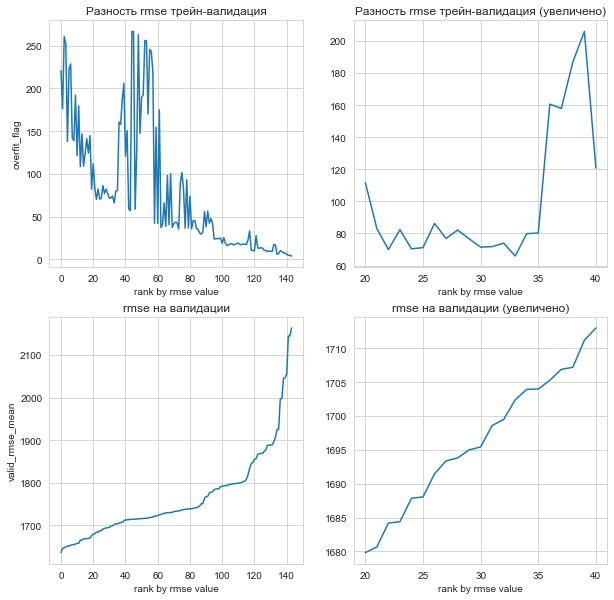

In [151]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex=False)

sns.lineplot(ax=axs[0][0], x=cv_df.index, y='overfit_flag', data=cv_df)
sns.lineplot(ax=axs[0][1], data=cv_df.loc[20:40, 'overfit_flag'])
sns.lineplot(ax=axs[1][0], x=cv_df.index, y='valid_rmse_mean', data=cv_df)
sns.lineplot(ax=axs[1][1], data=cv_df.loc[20:40, 'valid_rmse_mean'])
for ax1 in axs:
    for ax in ax1:
        ax.set_xlabel('rank by rmse value')
axs[0][0].set_title('Разность rmse трейн-валидация')
axs[0][1].set_title('Разность rmse трейн-валидация (увеличено)')
axs[1][0].set_title('rmse на валидации')
axs[1][1].set_title('rmse на валидации (увеличено)')
plt.show()

Видно, что модель склонна переучиваться (различается rmse на валидации и трейне). Причём переобучение характерно для параметров с рангами 0-20 и 35-60. Нужно выбрать не слишком низкий ранг и не слишком "переучивающую" комбинацию параметров. Посмотрим на параметры рангов 20-25

In [152]:
list(cv_df.loc[20:25, 'parameters'])

["{'early_stopping_rounds': 10, 'learning_rate': 0.2, 'min_data_in_leaf': 1000, 'num_leaves': 64, 'num_round': 50}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.1, 'min_data_in_leaf': 500, 'num_leaves': 32, 'num_round': 100}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.05, 'min_data_in_leaf': 1000, 'num_leaves': 32, 'num_round': 200}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.1, 'min_data_in_leaf': 500, 'num_leaves': 16, 'num_round': 200}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.1, 'min_data_in_leaf': 1000, 'num_leaves': 32, 'num_round': 100}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.1, 'min_data_in_leaf': 1000, 'num_leaves': 16, 'num_round': 200}"]

In [153]:
list(cv_df.loc[40:60, 'parameters'])

["{'early_stopping_rounds': 10, 'learning_rate': 0.5, 'min_data_in_leaf': 5000, 'num_leaves': 16, 'num_round': 200}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.5, 'min_data_in_leaf': 1000, 'num_leaves': 16, 'num_round': 100}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.05, 'min_data_in_leaf': 1000, 'num_leaves': 64, 'num_round': 100}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.2, 'min_data_in_leaf': 5000, 'num_leaves': 16, 'num_round': 200}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.5, 'min_data_in_leaf': 500, 'num_leaves': 64, 'num_round': 200}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.5, 'min_data_in_leaf': 500, 'num_leaves': 64, 'num_round': 100}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.1, 'min_data_in_leaf': 1000, 'num_leaves': 64, 'num_round': 50}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.5, 'min_data_in_leaf': 1000, 'num_leaves': 8, 'num_round': 200}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.5, 'min_

У переобученных моделей высокий learning_rate.
Из моделей, не сильно склонных к переобучению, мне нравятся rank 22, 24, 25

In [154]:
list(cv_df.loc[[22, 24, 25], 'parameters'])

["{'early_stopping_rounds': 10, 'learning_rate': 0.05, 'min_data_in_leaf': 1000, 'num_leaves': 32, 'num_round': 200}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.1, 'min_data_in_leaf': 1000, 'num_leaves': 32, 'num_round': 100}",
 "{'early_stopping_rounds': 10, 'learning_rate': 0.1, 'min_data_in_leaf': 1000, 'num_leaves': 16, 'num_round': 200}"]

In [155]:
cv_df.loc[22, :]

parameters            {'early_stopping_rounds': 10, 'learning_rate':...
training_rmse_0                                                 1613.66
training_rmse_1                                                 1614.02
training_rmse_2                                                 1611.84
training_rmse_3                                                 1618.56
training_rmse_4                                                  1613.2
valid_1_rmse_0                                                  1692.32
valid_1_rmse_1                                                  1682.02
valid_1_rmse_2                                                  1694.52
valid_1_rmse_3                                                  1665.12
valid_1_rmse_4                                                  1686.97
best_iterations_0                                                   200
best_iterations_1                                                   200
best_iterations_2                                               

Суть у них примерно одинакова. Либо больше листьев-меньше шагов, либо меньше размер шага ('learning_rate'). Количеством объектов в листе. rank 22 лучше по метрике. Выберу этот вариант. 'early_stopping_rounds' уберу, т.к число best_iterations в итоге было 200.

In [156]:
model_params = \
{'learning_rate': 0.05, 
 'min_data_in_leaf': 1000, 
 'num_leaves': 32, 
 'num_round': 200,
 'metric': 'rmse'}

encoder = TargetEncoder()
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols], y_train)
X_test[cat_cols] = encoder.transform(X_test[cat_cols])     

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
start = datetime.now()
final_model = lgb.train(model_params, train_data, valid_sets=[train_data, test_data])
end = datetime.now()
fitting_time = end - start

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 253648, number of used features: 11
[LightGBM] [Info] Start training from score 4610.360649
[1]	training's rmse: 4361.25	valid_1's rmse: 4343.04
[2]	training's rmse: 4205.34	valid_1's rmse: 4188.95
[3]	training's rmse: 4059.65	valid_1's rmse: 4044.45
[4]	training's rmse: 3921.39	valid_1's rmse: 3907.1
[5]	training's rmse: 3792.91	valid_1's rmse: 3780
[6]	training's rmse: 3670.9	valid_1's rmse: 3659.15
[7]	training's rmse: 3555.42	valid_1's rmse: 3545.25
[8]	training's rmse: 3447.49	valid_1's rmse: 3438.86
[9]	training's rmse: 3346.68	valid_1's rmse: 3339.19
[10]	training's rmse: 3251.99	valid_1's rmse: 3245.76
[11]	training's rmse: 3162.81	valid_1's rmse: 3157.59
[12]	tra

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))



[14]	training's rmse: 2926.37	valid_1's rmse: 2923.96
[15]	training's rmse: 2857.64	valid_1's rmse: 2856.08
[16]	training's rmse: 2792.88	valid_1's rmse: 2792.32
[17]	training's rmse: 2732.18	valid_1's rmse: 2732.2
[18]	training's rmse: 2674.41	valid_1's rmse: 2675.07
[19]	training's rmse: 2621.31	valid_1's rmse: 2622.64
[20]	training's rmse: 2570.54	valid_1's rmse: 2572.58
[21]	training's rmse: 2522.81	valid_1's rmse: 2525.71
[22]	training's rmse: 2476.97	valid_1's rmse: 2480.25
[23]	training's rmse: 2434.71	valid_1's rmse: 2438.69
[24]	training's rmse: 2394.11	valid_1's rmse: 2398.51
[25]	training's rmse: 2356.73	valid_1's rmse: 2361.49
[26]	training's rmse: 2321.4	valid_1's rmse: 2326.7
[27]	training's rmse: 2288.2	valid_1's rmse: 2294
[28]	training's rmse: 2256.86	valid_1's rmse: 2263.31
[29]	training's rmse: 2227.04	valid_1's rmse: 2233.86
[30]	training's rmse: 2199.59	valid_1's rmse: 2206.97
[31]	training's rmse: 2173.22	valid_1's rmse: 2181.01
[32]	training's rmse: 2148.84	vali

[176]	training's rmse: 1631.2	valid_1's rmse: 1684.73
[177]	training's rmse: 1630.42	valid_1's rmse: 1684.11
[178]	training's rmse: 1629.74	valid_1's rmse: 1683.73
[179]	training's rmse: 1628.63	valid_1's rmse: 1683.11
[180]	training's rmse: 1628	valid_1's rmse: 1682.67
[181]	training's rmse: 1627.61	valid_1's rmse: 1682.46
[182]	training's rmse: 1626.97	valid_1's rmse: 1682.12
[183]	training's rmse: 1626.53	valid_1's rmse: 1681.87
[184]	training's rmse: 1625.84	valid_1's rmse: 1681.43
[185]	training's rmse: 1625.28	valid_1's rmse: 1681.12
[186]	training's rmse: 1624.71	valid_1's rmse: 1680.81
[187]	training's rmse: 1623.74	valid_1's rmse: 1680.33
[188]	training's rmse: 1623.38	valid_1's rmse: 1680.2
[189]	training's rmse: 1622.68	valid_1's rmse: 1679.79
[190]	training's rmse: 1621.84	valid_1's rmse: 1679.44
[191]	training's rmse: 1621.47	valid_1's rmse: 1679.26
[192]	training's rmse: 1620.91	valid_1's rmse: 1678.93
[193]	training's rmse: 1620.51	valid_1's rmse: 1678.8
[194]	training's

In [157]:
print(f'Time spent on model fitting, dataset shape {X_train.shape}:', fitting_time)
start = datetime.now()
y_predicted = final_model.predict(X_test)
end = datetime.now()
prediction_time = end - start
print(f'Time spent on prediction, dataset shape {X_test.shape}:', prediction_time)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_predicted)))

Time spent on model fitting, dataset shape (253648, 11): 0:00:02.347134
Time spent on prediction, dataset shape (84550, 11): 0:00:00.679314
RMSE: 1676.877999472875


Полученная метрика на тесте даже чуть лучше, чем на валидации. Посмотрю на важности фич для этой модели.

In [158]:
feature_importances = pd.DataFrame(data=final_model.feature_importance())
feature_importances.index = X_train.columns
feature_importances.columns = ['importance']
feature_importances.sort_values(by='importance', ascending=False)

,importance
Model,1880
age_in_years,1085
post_zone_region,968
Power,679
Brand,457
Kilometer,449
VehicleType,328
NotRepaired,179
FuelType,97
Gearbox,77


Самые важные признаки - Модель, возраст и регион продажи. За ними - мощность, бренд, пробег и тип кузова. 'post_zone' в предсказании практически не используется, можно удалить признак. Прогоню заново пайплайн

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

X_train.drop(columns=['post_zone'], inplace=True)
X_test.drop(columns=['post_zone'], inplace=True)

cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
                    'Brand', 'NotRepaired', 'post_zone_region']

encoder = TargetEncoder()
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols], y_train)
X_test[cat_cols] = encoder.transform(X_test[cat_cols])     

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)
start = datetime.now()
final_model = lgb.train(model_params, train_data, valid_sets=[train_data, test_data])
end = datetime.now()
fitting_time = end - start

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 719
[LightGBM] [Info] Number of data points in the train set: 253648, number of used features: 10
[LightGBM] [Info] Start training from score 4610.360649
[1]	training's rmse: 4361.25	valid_1's rmse: 4343.04
[2]	training's rmse: 4205.34	valid_1's rmse: 4188.95
[3]	training's rmse: 4059.65	valid_1's rmse: 4044.45
[4]	training's rmse: 3921.39	valid_1's rmse: 3907.1
[5]	training's rmse: 3792.91	valid_1's rmse: 3780
[6]	training's rmse: 3670.9	valid_1's rmse: 3659.15
[7]	training's rmse: 3555.42	valid_1's rmse: 3545.25
[8]	training's rmse: 3447.49	valid_1's rmse: 3438.86
[9]	training's rmse: 3346.68	valid_1's rmse: 3339.19
[10]	training's rmse: 3251.99	valid_1's rmse: 3245.76
[11]	training's rmse: 3162.81	valid_1's rmse: 3157.59
[12]	tra

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))



[13]	training's rmse: 3000.54	valid_1's rmse: 2997.44
[14]	training's rmse: 2926.37	valid_1's rmse: 2923.96
[15]	training's rmse: 2857.64	valid_1's rmse: 2856.08
[16]	training's rmse: 2792.88	valid_1's rmse: 2792.32
[17]	training's rmse: 2732.18	valid_1's rmse: 2732.2
[18]	training's rmse: 2674.41	valid_1's rmse: 2675.07
[19]	training's rmse: 2621.31	valid_1's rmse: 2622.64
[20]	training's rmse: 2570.54	valid_1's rmse: 2572.58
[21]	training's rmse: 2522.81	valid_1's rmse: 2525.71
[22]	training's rmse: 2476.97	valid_1's rmse: 2480.25
[23]	training's rmse: 2434.71	valid_1's rmse: 2438.69
[24]	training's rmse: 2394.11	valid_1's rmse: 2398.51
[25]	training's rmse: 2356.73	valid_1's rmse: 2361.49
[26]	training's rmse: 2321.4	valid_1's rmse: 2326.7
[27]	training's rmse: 2288.2	valid_1's rmse: 2294
[28]	training's rmse: 2256.86	valid_1's rmse: 2263.31
[29]	training's rmse: 2227.04	valid_1's rmse: 2233.86
[30]	training's rmse: 2199.59	valid_1's rmse: 2206.97
[31]	training's rmse: 2173.22	vali

[183]	training's rmse: 1625.78	valid_1's rmse: 1682
[184]	training's rmse: 1625.24	valid_1's rmse: 1681.58
[185]	training's rmse: 1624.64	valid_1's rmse: 1681.28
[186]	training's rmse: 1623.93	valid_1's rmse: 1680.89
[187]	training's rmse: 1623.08	valid_1's rmse: 1680.47
[188]	training's rmse: 1622.39	valid_1's rmse: 1680.04
[189]	training's rmse: 1622.02	valid_1's rmse: 1679.86
[190]	training's rmse: 1621.52	valid_1's rmse: 1679.62
[191]	training's rmse: 1620.98	valid_1's rmse: 1679.37
[192]	training's rmse: 1620.56	valid_1's rmse: 1679.11
[193]	training's rmse: 1619.85	valid_1's rmse: 1678.76
[194]	training's rmse: 1619.19	valid_1's rmse: 1678.47
[195]	training's rmse: 1618.75	valid_1's rmse: 1678.2
[196]	training's rmse: 1618.14	valid_1's rmse: 1677.87
[197]	training's rmse: 1617.57	valid_1's rmse: 1677.57
[198]	training's rmse: 1617.19	valid_1's rmse: 1677.45
[199]	training's rmse: 1616.76	valid_1's rmse: 1677.27
[200]	training's rmse: 1615.87	valid_1's rmse: 1676.84


In [160]:
print(f'Time spent on model fitting, dataset shape {X_train.shape}:', fitting_time)
start = datetime.now()
y_predicted = final_model.predict(X_test)
end = datetime.now()
prediction_time = end - start
print(f'Time spent on prediction, dataset shape {X_test.shape}:', prediction_time)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_predicted)))

Time spent on model fitting, dataset shape (253648, 10): 0:00:02.242182
Time spent on prediction, dataset shape (84550, 10): 0:00:00.802520
RMSE: 1676.8409944283299


Особых изменений нет, но признаков меньше, это неплохо.

In [161]:
feature_importances = pd.DataFrame(data=final_model.feature_importance())
feature_importances.index = X_train.columns
feature_importances.columns = ['importance']
feature_importances.sort_values(by='importance', ascending=False)

,importance
Model,1889
age_in_years,1097
post_zone_region,966
Power,653
Brand,460
Kilometer,449
VehicleType,329
NotRepaired,179
FuelType,108
Gearbox,70


Напишу класс, реализующий данный пайплайн

In [162]:
class PredictPipeline:
    def __init__(self, booster, encoder):
        self.bst = booster
        self.enc = encoder
    
    def transform(self, X):
        
        X=X.copy()

        try:
            X.drop(columns=['Price'], inplace=True)
        except:
            pass
        
        try:
            X.drop(columns=['post_zone'], inplace=True)
        except:
            pass

        try:
            X.loc[:, 'age_in_years'] = X['DateCreated'].dt.year - X['RegistrationYear']
        except:
            pass

        try:
            X.loc[:, 'post_zone_region'] = (X['PostalCode']/1000).astype(int)
        except:
            pass

        try:
            X.drop(columns=['DateCrawled', 
                            'RegistrationYear',
                            'RegistrationMonth',
                            'DateCreated',
                            'NumberOfPictures',
                            'PostalCode',
                            'LastSeen'
                           ], inplace=True)
        except:
            pass
            
        cat_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
                    'Brand', 'NotRepaired', 'post_zone_region']
        
        X[cat_cols] = self.enc.transform(X[cat_cols])
        X[cat_cols] = X[cat_cols].astype('category')
        X[cat_cols] = X[cat_cols].astype('category')
               
        return X
    
    def predict(self, X):
        try:
            X.drop(columns=['Price'], inplace=True)
        except:
            pass
        
        prediction = self.bst.predict(X)
        
        return prediction
    
    def transform_predict(self, X):
        transformed_x = self.transform(X)
        return self.predict(transformed_x)

Проверю корректность его работы на X_test:

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)
predictor = PredictPipeline(final_model, encoder)
np.sqrt(mean_squared_error(y_test,predictor.transform_predict(X_test)))

1676.8409944283299

Метрики не отличаются, класс работает корректно

**Итак, финальная модель:**

LightGBM с параметрами:

model_params = \
{'learning_rate': 0.05, 
 'min_data_in_leaf': 1000, 
 'num_leaves': 32, 
 'num_round': 200,
 'metric': 'rmse'}

**Финальный набор признаков:**

['VehicleType',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'FuelType',
 'Brand',
 'NotRepaired',
 'age_in_years',
 'post_zone_region']

**Финальный пайплайн:**

- Кодирование категориальных признаков ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'post_zone_region'] с помощью TargetEncoder()

- Преобразование типа этих признаков к category (чтобы с ними мог работать LightGBM своими методами)

- Прогноз с помощью LightGBM {'learning_rate': 0.05, 'min_data_in_leaf': 1000, 'num_leaves': 32, 'num_round': 200, 'metric': 'rmse'}

Ради интереса прогоню на изначальном датасете, чтобы посмотреть, как влияет загрязнение данных на результат

In [164]:
df_pipe_test = pd.read_csv(link+'autos.csv', 
                parse_dates=['DateCrawled', 'DateCreated', 'LastSeen']
                )

In [165]:
np.sqrt(mean_squared_error(df_pipe_test['Price'],predictor.transform_predict(df_pipe_test)))

2165.3699191234355

Да, метрика ухудшилась. Загрязнение данных даёт о себе знать. 

Для сравнения, на очищенном полном наборе данных:

In [166]:
np.sqrt(mean_squared_error(y,predictor.transform_predict(X)))

1631.3260564600732

<h1 style="color:SteelBlue">Общий вывод</h1>

Входные данные проекта - довольно загрязнённые данные, похоже, с двух площадок, содержащие информацию о продажах авто в Германии (по большей части). Большинство признаков - категориальные. Думаю, при наличи времени на feature engineering и эксперименты с кодированием, результат можно было бы улучшить.


Выполнил очистку данных. Выявил, что данные содержат нули в тех признаках, где их быть не может. Сделал вывод, что нулями заполнены отсутствующие значения. Заполнил их обратно np.nan, чтобы потом подобрать методы обработки и заполнения пропусков. В данных были аномально низкие цены на автомобили, автомобили "моложе", чем дата подачи объявления о продажи, автомобили с возрастом в 1000 лет, автомобили с аномально высокой мощностью двигателя, автомобили первого года с аномально высокими пробегами. Пробеги подозрительно распределены (дискретно). Нашёл rover'ы, которые на самомо деле land_rover'ы. Нашёл автомобили, которые ездят на petrol и gasoline, хотя и то и то - бензин (и эти категории значимо отличаются по средней цене авто и по распределению цены). Часть подозрительных объектов удалил, в части - заполнил подозрительные признаки np.nan.

Попробовал заполнить пропуски на основании других данных объекта. Допустим, по сочетанию *модель-бренд-год выпуска* определить наиболее подходящий тип кузова. Попробовал кодировать признаки с большим числом категорий, заменяя категории на стандартизованное среднее значение цены авто для этой категории в тренировочной выборке. Для указанных операций написал 2 класса: DictionaryEncoder и DictionaryImputer

Сгенерировал параметры "возраст автомобиля в годах", "возраст автомобиля в месяцах", "почтовая зона", "почтовый регион". В финальном пайплайне из них осталось 2:  'age_in_years', 'post_zone_region'.

Обучил 4 модели: LinearRegression(), XGBoostRegressor(), CatBoostRegressor() и LGBRegressor(). LinearRegression() и XGBoostRegressor() выбыли из-за метрики/времени работы. Из оставшихся выбрал LGBRegressor(), как более быстрый алгоритм с лучшим значением метрики.

Подобрал оптимальный вариант предобработки данных для этой модели. Получилось, что нужно закодировать категориальные признаки TargetEncoder() и далее преобразовать в тип 'category'. Затем передать в модель.

Параметры модели подобрал с помощью поиска по сетке. Написал свою функцию, т.к. функционал GridSearch меня не устроил в данном случае. При подборе параметров учитывал возможное переобучение по разнице между метриками на трейне и валидации.

**Финальный пайплайн:**

- Кодирование категориальных признаков <code>['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'post_zone_region']</code> с помощью <code>TargetEncoder()</code>

- Преобразование типа этих признаков к <code>category</code> (чтобы с ними мог работать LightGBM своими методами)

- Прогноз с помощью <code>LightGBM {'learning_rate': 0.05, 'min_data_in_leaf': 1000, 'num_leaves': 32, 'num_round': 200, 'metric': 'rmse'}</code>

**Набор признаков**

<code>['VehicleType', 'Gearbox', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'NotRepaired', 'age_in_years', 'post_zone_region']</code>
 
 **Результат на тесте**
 

- **Time spent on model fitting, dataset shape (253648, 10): 0:00:02.303809**

- **Time spent on prediction, dataset shape (84550, 10): 0:00:00.813823**

- **RMSE: 1676.8409944283299**


Полагаю, результат можно улучшить как дополнительной оптимизацией гиперпараметров, так и с помощью feature engineering и углублённой очистки и корректировки ошибок в данных